# Methodological Foundation of a Numerical Taxonomy of Urban Form

This notebook serves as a template for morphometric assessment and generation of a taxonomy.

## Reproducible Python code to generate taxonomy

Complete morphometrics assessment from input data to taxonomy.

Input data:
 - building footprints
 - street network
 
This notebook is running the analysis on the sample of the data used in Prague case study. You can replace the sample with your own data, assuming that they are cleaned to a required standard. 

The sample is saved in `../files/sample.gpkg` with two layers named `buildings` and `streets`. `buildings` are Polygons, whilst `streets` are LineStrings.

Buildings data contain a single attribute column:

- `height` - building height in meters.

This notebook has been updated to work with `momepy` 0.5 and `geopandas` 0.10. The original work has been carried out using `momepy` 0.3 within the Docker container `darribas/gds_py:5.0`.

All data generated throughout the method are saved to files (unless commented out).

First we import all required libraries.

In [1]:
import warnings
import shapely
import math

from shapely.geometry import Polygon
from factor_analyzer import calculate_kmo,FactorAnalyzer
import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import scipy.spatial.distance
import seaborn as sns
import factor_analyzer
from factor_analyzer.factor_analyzer import calculate_kmo,calculate_bartlett_sphericity
from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN,SpectralClustering,BisectingKMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check the input data

We load buildings and create unique ID.

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 21382 (\N{CJK UNIFIED IDEOGRAPH-5386}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 21490 (\N{CJK UNIFIED IDEOGRAPH-53F2}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 35980 (\N{CJK UNIFIED IDEOGRAPH-8C8C}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning:

<AxesSubplot: >

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21382 (\N{CJK UNIFIED IDEOGRAPH-5386}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21490 (\N{CJK UNIFIED IDEOGRAPH-53F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35980 (\N{CJK UNIFIED IDEOGRAPH-8C8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6

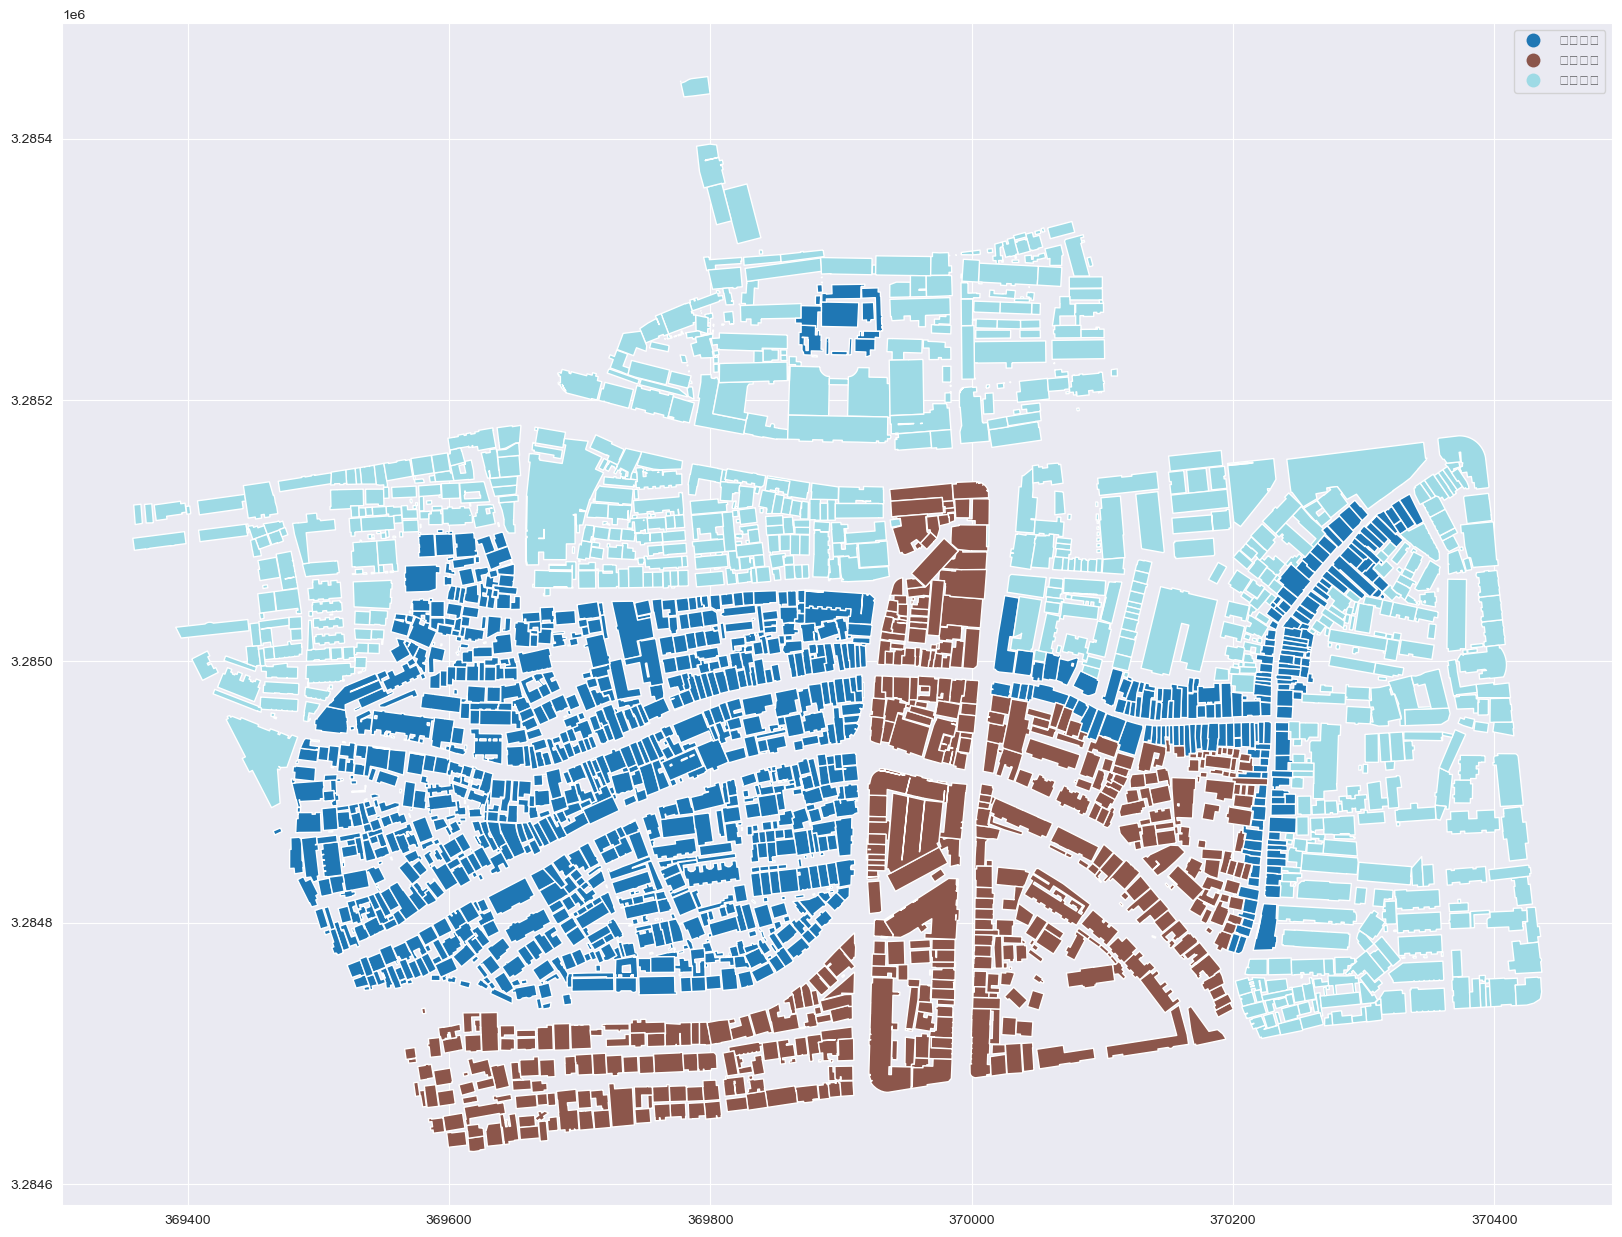

In [2]:
# 这是自己的模型
path = "../files/buildings_hebing_0413.parquet"
buildings = gpd.read_parquet(path)
buildings=buildings.rename({'Elevation':'height','功能大':'功能','材质大':'材质','Text':'结构','建筑产':'产权','风貌分':'风貌','Shape_Leng':'Peri','Shape_Area':'Area'},axis=1)
buildings['height']=np.round(buildings['height'],2)
buildings_cate=buildings.loc[:,['功能','材质','结构','产权','风貌']]
buildings_morph=buildings.loc[:,['height','geometry','Area','Peri']]
buildings.plot('风貌', categorical=True, cmap='tab20', legend=True, figsize=(20, 20))

In [3]:
buildings['uID']=range(len(buildings))

<AxesSubplot: >

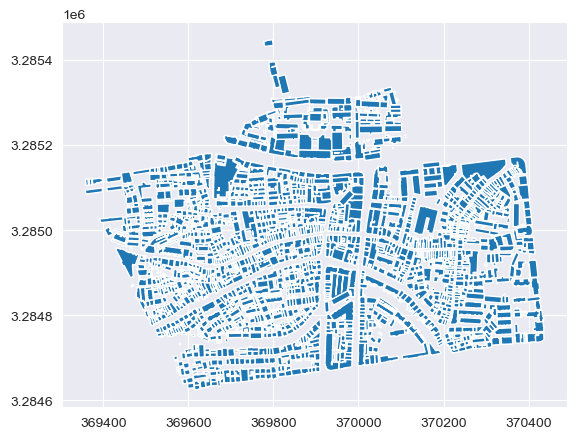

In [4]:
buildings.plot(figsize=(10,5))

In [5]:
list1=list()
buildings_cate=pd.DataFrame(buildings_cate)
for name in ['功能','材质','结构','产权','风貌']:
    list1.append(buildings_cate[f'{name}'].unique().size)
sum=0
buildings_cate=pd.get_dummies(buildings_cate)
cate_namelist=list(buildings_cate.columns)
# for count in list1:
#     for i in range(count):
#         buildings_cate.iloc[:,sum+i-1]=buildings_cate.iloc[:,sum+i-1]/np.sqrt(count)
#     sum+=count
# count_change=list1[-1]
# for i in range(-1,-count_change-1,-1):
#     buildings_cate.iloc[:,i]=buildings_cate.iloc[:,i]*10
# buildings_cate


In [6]:
buildings_cate_compressed=buildings_cate
buildings_cate_compressed["uID"] = range(len(buildings))

In [7]:
buildings_morph

height                                           geometry        Area  \
0      25.33  POLYGON ((370207.977 3285052.966, 370215.201 3...   33.407947   
1      27.66  POLYGON ((370431.450 3284811.745, 370433.167 3...  228.626191   
2      34.88  POLYGON ((370294.740 3284856.691, 370295.160 3...  272.304471   
3      32.41  POLYGON ((370293.387 3284868.053, 370293.441 3...  321.855976   
4      30.46  POLYGON ((370252.116 3284911.116, 370252.102 3...   73.682953   
...      ...                                                ...         ...   
2429    0.00  POLYGON ((369782.476 3285203.167, 369782.242 3...  149.088567   
2430    0.00  POLYGON ((369784.018 3285221.628, 369783.389 3...    0.379340   
2431    0.00  POLYGON ((369782.900 3285226.153, 369782.270 3...    0.379340   
2432   29.98  POLYGON ((370233.343 3285042.880, 370233.324 3...   13.770344   
2433   21.49  POLYGON ((369455.695 3284996.928, 369454.122 3...   48.990911   

           Peri  
0     25.039392  
1     74.469661  
2     72.462176  
3     77.478165  
4     34.793896  
...         ...  
2429  81.086345  
2430   2.466083  
2431   2.466083  
2432  14.958105  
2433  33.699210  

[2434 rows x 4 columns]

Let's create a persistent unique identifier for each building.

In [8]:

buildings_morph["uID"] = range(len(buildings))


### Generate additional morphometric elements

Before we can start morhometrics we have to generate additional elements - tessellation and tessellation based blocks.

#### Morphological tessellation

Check input for tessellation. If the input data is clean, the check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [9]:
check = mm.CheckTessellationInput(buildings_morph,shrink=0.1)

Collapsed features  : 0
Split features      : 6
Overlapping features: 21


C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\preprocessing.py:387: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  over_rows = sorted(overlapping.origin.append(overlapping.dest).unique())


Generate tessellation limited to 100 m buffer. Beware, it is memory demanding.

**Note:** You may find that this step requires more memory that you are able to provide. In that case, you may consider using an [enclosed tessellation](http://docs.momepy.org/en/stable/user_guide/elements/enclosed.html) method instead. However, that would require minor adaptation of the code below as well.

In [10]:
limit = mm.buffered_limit(buildings_morph, 10)

tessellation = mm.Tessellation(buildings_morph, "uID", limit, verbose=False,shrink=0.1)
tessellation = tessellation.tessellation

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:277: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  objects.loc[mask, objects.geometry.name] = objects[mask].buffer(
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\tools\clip.py:48: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:383: UserWarning: Tessellation does not fully match buildings. 3 element(s) collapsed during generation - unique_id: {2289, 2290, 2284}
  warnings.

In [11]:
tessellation

uID                                           geometry
1084  1084  POLYGON ((369664.284 3284625.754, 369664.688 3...
1061  1061  POLYGON ((369725.796 3284637.123, 369724.446 3...
1063  1063  POLYGON ((369711.717 3284635.836, 369711.112 3...
1774  1774  POLYGON ((369746.703 3284636.349, 369746.059 3...
1055  1055  POLYGON ((369771.741 3284641.896, 369772.065 3...
...    ...                                                ...
2401  2404  POLYGON ((369760.976 3285245.436, 369760.613 3...
2403  2406  POLYGON ((369731.458 3285221.058, 369731.354 3...
2402  2405  POLYGON ((369753.996 3285232.514, 369753.455 3...
2418  2421  POLYGON ((369678.240 3285204.926, 369679.590 3...
2284  2285  POLYGON ((369772.128 3285425.471, 369771.540 3...

[2431 rows x 2 columns]

<AxesSubplot: >

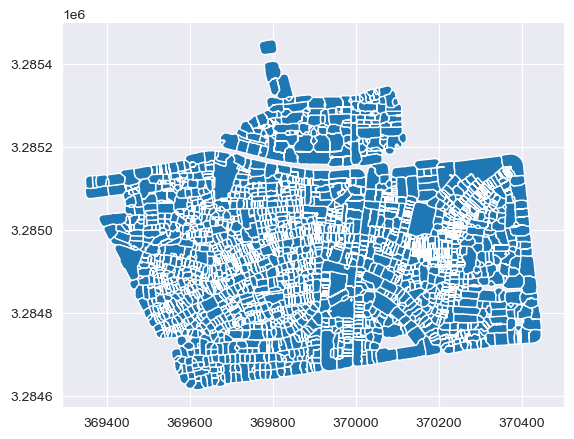

In [12]:
tessellation.plot(figsize=(10,5))

We save tessellation to file. Note that this file is not part of the repository but can be fully created using the input sample and this notebook.

In [13]:
tessellation.to_file("../files/geometry.gpkg", layer="tessellation")

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Tessellation based blocks

To generate tessellation based blocks we also need street network, therefore we need to read it to GeoDataFrame first.

In [14]:
path = "../files/streets.shp"
streets = gpd.read_file(path)
streets=gpd.GeoDataFrame(streets['geometry'])

In [15]:
streets

geometry
0   LINESTRING (369748.161 3284121.735, 369586.261...
1   LINESTRING (370165.482 3285171.342, 370155.930...
2   LINESTRING (368408.136 3284728.424, 369303.340...
3   LINESTRING (370409.997 3285199.176, 370488.402...
4   LINESTRING (370334.225 3285134.783, 370345.756...
..                                                ...
91  LINESTRING (369772.377 3284779.055, 369784.453...
92  LINESTRING (369650.954 3285034.888, 369657.080...
93  LINESTRING (369988.226 3285150.391, 369986.667...
94  LINESTRING (369817.604 3285323.260, 369886.863...
95  LINESTRING (369847.084 3284980.279, 369857.695...

[96 rows x 1 columns]

<AxesSubplot: >

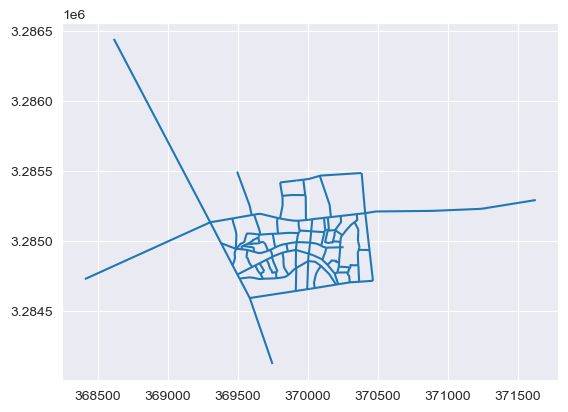

In [16]:

streets.plot()

To create blocks within the full `limit`, it is always safer to extend street network to the edge of the limit.

In [17]:
extended = mm.extend_lines(streets, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

In [18]:
blocks = mm.Blocks(tessellation, edges=extended, buildings=buildings_morph, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks  # get blocks df
buildings_morph['bID'] = blocks.buildings_id.values  # get block ID
tessellation['bID'] = blocks.tessellation_id.values  # get block ID
blocks_df

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))


bID                                           geometry
0     0  POLYGON ((369630.860 3284617.050, 369629.940 3...
1     1  POLYGON ((369827.673 3284832.393, 369828.002 3...
2     2  POLYGON ((369748.046 3284776.532, 369748.416 3...
3     3  POLYGON ((369870.067 3284763.698, 369869.696 3...
4     4  POLYGON ((369756.936 3284775.171, 369756.824 3...
5     5  POLYGON ((369664.036 3284756.303, 369664.092 3...
6     6  POLYGON ((369569.805 3284795.274, 369569.731 3...
7     7  POLYGON ((369474.318 3284880.609, 369475.138 3...
8     8  POLYGON ((369462.278 3284953.123, 369461.077 3...
9     9  POLYGON ((369495.130 3284953.870, 369495.103 3...
10   10  POLYGON ((369672.438 3284772.682, 369672.094 3...
11   11  POLYGON ((369706.010 3284956.438, 369706.410 3...
12   12  POLYGON ((369592.985 3284929.925, 369592.895 3...
13   13  POLYGON ((369713.143 3284939.329, 369713.124 3...
14   14  POLYGON ((369743.873 3284893.464, 369743.700 3...
15   15  POLYGON ((369860.521 3284931.089, 369860.745 3...
16   16  POLYGON ((369527.715 3284951.015, 369527.979 3...
17   17  POLYGON ((369579.981 3284980.783, 369579.988 3...
18   18  POLYGON ((369770.308 3284963.223, 369770.173 3...
19   19  POLYGON ((369761.710 3285052.189, 369761.207 3...
20   20  POLYGON ((369844.308 3285151.872, 369845.288 3...
21   21  POLYGON ((369992.775 3284676.230, 369992.886 3...
22   22  POLYGON ((370016.092 3284672.516, 370015.115 3...
23   23  POLYGON ((369912.382 3284803.359, 369912.098 3...
24   24  POLYGON ((370097.647 3284713.766, 370098.505 3...
25   25  POLYGON ((370236.193 3284703.942, 370224.127 3...
26   26  POLYGON ((370203.163 3284736.528, 370203.199 3...
27   27  POLYGON ((370198.089 3284768.863, 370198.039 3...
28   28  POLYGON ((370286.114 3284776.392, 370285.985 3...
29   29  POLYGON ((370394.574 3284725.330, 370390.144 3...
30   30  POLYGON ((370137.525 3284833.602, 370137.217 3...
31   31  POLYGON ((370322.497 3284719.847, 370321.930 3...
32   32  POLYGON ((370096.094 3284867.346, 370095.665 3...
33   33  POLYGON ((370231.928 3284981.121, 370231.949 3...
34   34  POLYGON ((369992.276 3284911.732, 369992.252 3...
35   35  POLYGON ((370379.337 3284946.756, 370378.924 3...
36   36  POLYGON ((370226.648 3284997.720, 370226.304 3...
37   37  POLYGON ((370229.956 3285052.812, 370229.766 3...
38   38  POLYGON ((370172.653 3284989.665, 370172.359 3...
39   39  POLYGON ((370074.452 3284978.023, 370074.432 3...
40   40  POLYGON ((370114.097 3285063.669, 370113.729 3...
41   41  POLYGON ((369946.418 3284992.448, 369945.914 3...
42   42  POLYGON ((369962.664 3285058.583, 369962.294 3...
43   43  POLYGON ((370070.429 3285194.832, 370070.100 3...
44   44  POLYGON ((369987.575 3285175.849, 369987.595 3...
45   45  POLYGON ((370150.641 3285080.629, 370150.753 3...
46   46  POLYGON ((370141.750 3285078.906, 370141.287 3...
47   47  POLYGON ((369813.941 3285316.038, 369813.414 3...
48   48  POLYGON ((369819.652 3285269.876, 369819.827 3...
49   49  POLYGON ((369811.243 3285362.742, 369810.998 3...
50   50  POLYGON ((369772.128 3285425.471, 369771.540 3...

#### Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [19]:
streets["nID"] = range(len(streets))
buildings_morph['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)
tessellation = tessellation.merge(buildings_morph[['uID', 'nID']], on='uID', how='left')

Finally, we save elements to a file.

In [20]:
path = '../files/geometry.gpkg'
tessellation.to_file(path, layer='tessellation', driver='GPKG')
buildings_morph.to_file(path, layer='buildings', driver='GPKG')
blocks_df.to_file(path, layer='blocks', driver='GPKG')

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Measure primary characters

This part measures 74 primary morphometric characters.

It does save intermediate parquet files as a backup.

In [21]:
blocks = blocks_df
blocks_df

bID                                           geometry
0     0  POLYGON ((369630.860 3284617.050, 369629.940 3...
1     1  POLYGON ((369827.673 3284832.393, 369828.002 3...
2     2  POLYGON ((369748.046 3284776.532, 369748.416 3...
3     3  POLYGON ((369870.067 3284763.698, 369869.696 3...
4     4  POLYGON ((369756.936 3284775.171, 369756.824 3...
5     5  POLYGON ((369664.036 3284756.303, 369664.092 3...
6     6  POLYGON ((369569.805 3284795.274, 369569.731 3...
7     7  POLYGON ((369474.318 3284880.609, 369475.138 3...
8     8  POLYGON ((369462.278 3284953.123, 369461.077 3...
9     9  POLYGON ((369495.130 3284953.870, 369495.103 3...
10   10  POLYGON ((369672.438 3284772.682, 369672.094 3...
11   11  POLYGON ((369706.010 3284956.438, 369706.410 3...
12   12  POLYGON ((369592.985 3284929.925, 369592.895 3...
13   13  POLYGON ((369713.143 3284939.329, 369713.124 3...
14   14  POLYGON ((369743.873 3284893.464, 369743.700 3...
15   15  POLYGON ((369860.521 3284931.089, 369860.745 3...
16   16  POLYGON ((369527.715 3284951.015, 369527.979 3...
17   17  POLYGON ((369579.981 3284980.783, 369579.988 3...
18   18  POLYGON ((369770.308 3284963.223, 369770.173 3...
19   19  POLYGON ((369761.710 3285052.189, 369761.207 3...
20   20  POLYGON ((369844.308 3285151.872, 369845.288 3...
21   21  POLYGON ((369992.775 3284676.230, 369992.886 3...
22   22  POLYGON ((370016.092 3284672.516, 370015.115 3...
23   23  POLYGON ((369912.382 3284803.359, 369912.098 3...
24   24  POLYGON ((370097.647 3284713.766, 370098.505 3...
25   25  POLYGON ((370236.193 3284703.942, 370224.127 3...
26   26  POLYGON ((370203.163 3284736.528, 370203.199 3...
27   27  POLYGON ((370198.089 3284768.863, 370198.039 3...
28   28  POLYGON ((370286.114 3284776.392, 370285.985 3...
29   29  POLYGON ((370394.574 3284725.330, 370390.144 3...
30   30  POLYGON ((370137.525 3284833.602, 370137.217 3...
31   31  POLYGON ((370322.497 3284719.847, 370321.930 3...
32   32  POLYGON ((370096.094 3284867.346, 370095.665 3...
33   33  POLYGON ((370231.928 3284981.121, 370231.949 3...
34   34  POLYGON ((369992.276 3284911.732, 369992.252 3...
35   35  POLYGON ((370379.337 3284946.756, 370378.924 3...
36   36  POLYGON ((370226.648 3284997.720, 370226.304 3...
37   37  POLYGON ((370229.956 3285052.812, 370229.766 3...
38   38  POLYGON ((370172.653 3284989.665, 370172.359 3...
39   39  POLYGON ((370074.452 3284978.023, 370074.432 3...
40   40  POLYGON ((370114.097 3285063.669, 370113.729 3...
41   41  POLYGON ((369946.418 3284992.448, 369945.914 3...
42   42  POLYGON ((369962.664 3285058.583, 369962.294 3...
43   43  POLYGON ((370070.429 3285194.832, 370070.100 3...
44   44  POLYGON ((369987.575 3285175.849, 369987.595 3...
45   45  POLYGON ((370150.641 3285080.629, 370150.753 3...
46   46  POLYGON ((370141.750 3285078.906, 370141.287 3...
47   47  POLYGON ((369813.941 3285316.038, 369813.414 3...
48   48  POLYGON ((369819.652 3285269.876, 369819.827 3...
49   49  POLYGON ((369811.243 3285362.742, 369810.998 3...
50   50  POLYGON ((369772.128 3285425.471, 369771.540 3...

In [22]:
buildings_morph['floor_area'] = (buildings_morph["height"] / 3.5) * buildings_morph.area

In [23]:
buildings_morph['sdbAre'] = mm.Area(buildings_morph).series
buildings_morph['sdbVol'] = mm.Volume(buildings_morph, 'height', 'sdbAre').series
buildings_morph['sdbPer'] = mm.Perimeter(buildings_morph).series
buildings_morph['ssbVFR'] = mm.VolumeFacadeRatio(buildings_morph, 'height', 'sdbVol', 'sdbPer').series
buildings_morph['ssbElo'] = mm.Elongation(buildings_morph).series

In [24]:
buildings_morph['stbOri'] = mm.Orientation(buildings_morph, verbose=False).series
tessellation['stcOri'] = mm.Orientation(tessellation, verbose=False).series
tessellation['sdcAre'] = mm.Area(tessellation).series

In [25]:
buildings_morph["mtbSWR"] = mm.SharedWallsRatio(buildings_morph, "sdbPer").series
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)
buildings_morph["mtbAli"] = mm.Alignment(buildings_morph, queen_1, "uID", "stbOri", verbose=False).series
buildings_morph["mtbNDi"] = mm.NeighborDistance(buildings_morph, queen_1, "uID", verbose=False).series
tessellation["mtcWNe"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["mdcAre"] = mm.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\distribution.py:491: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  data.iteritems(), total=data.shape[0], disable=not verbose
C:\Users\YAGA\anac

In [26]:
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings_morph, silence_warnings=True)

blocks["ldkAre"] = mm.Area(blocks).series
blocks["ldkPer"] = mm.Perimeter(blocks).series
blocks["ltkOri"] = mm.Orientation(blocks, verbose=False).series

blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID", silence_warnings=True)

blocks["ltkWNB"] = mm.Neighbors(blocks, blo_q1, "bID", weighted=True, verbose=False).series
blocks["likWBB"] = mm.Count(blocks, buildings_morph, "bID", "bID", weighted=True).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\distribution.py:905: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  gdf.set_index(unique_id).geometry.iteritems(),


Note: 

- `height` is building height in meters. If you do not have it, skip affected lines.

Save data to parquets as a checkpoint backup.

In [27]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings_morph.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
blocks.drop(columns='geometry').to_parquet('../files/blocks_data.parquet')

In [28]:
queen_3 = mm.sw_high(k=2, weights=queen_1)
tessellation = tessellation.merge(buildings_morph[['floor_area', 'uID']], on='uID', how='left')
tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
tessellation = tessellation.drop(columns='floor_area')
tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID', verbose=False).series
tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings_morph, 'sdcAre', 'sdbAre', 'uID').series
tessellation['sicFAR'] = mm.AreaRatio(tessellation, buildings_morph, 'sdcAre', 'floor_area', 'uID').series

100%|██████████| 2431/2431 [00:02<00:00, 1174.39it/s]


In [29]:
tessellation

uID                                           geometry  bID  nID  \
0     1084  POLYGON ((369664.284 3284625.754, 369664.688 3...    0   64   
1     1061  POLYGON ((369725.796 3284637.123, 369724.446 3...    0   64   
2     1063  POLYGON ((369711.717 3284635.836, 369711.112 3...    0   64   
3     1774  POLYGON ((369746.703 3284636.349, 369746.059 3...    0   64   
4     1055  POLYGON ((369771.741 3284641.896, 369772.065 3...    0   64   
...    ...                                                ...  ...  ...   
2426  2404  POLYGON ((369760.976 3285245.436, 369760.613 3...   48   84   
2427  2406  POLYGON ((369731.458 3285221.058, 369731.354 3...   48   60   
2428  2405  POLYGON ((369753.996 3285232.514, 369753.455 3...   48   60   
2429  2421  POLYGON ((369678.240 3285204.926, 369679.590 3...   48   60   
2430  2285  POLYGON ((369772.128 3285425.471, 369771.540 3...   50   18   

         stcOri       sdcAre    mtcWNe       mdcAre    licGDe    ltcWRB  \
0      8.257028   313.430406  0.060700  1746.877235  4.127369  0.000236   
1     12.767911   886.150367  0.051354  2807.718325  4.197224  0.000181   
2      5.245243   331.156253  0.049837  1991.892411  4.242902  0.000227   
3     11.759957   286.126767  0.057385  1798.219175  4.143630  0.000253   
4      8.330161   306.403672  0.053707  1173.938717  4.340237  0.000261   
...         ...          ...       ...          ...       ...       ...   
2426  22.597928   531.249049  0.047487  2112.103069  1.497122  0.000248   
2427  26.363049   379.863402  0.047531  3212.890947  0.000000  0.000159   
2428  29.854994   646.266809  0.037551  2376.643667  0.608771  0.000186   
2429  14.553632  1407.436020  0.031649  2792.682966  0.000000  0.000197   
2430   7.324474  1253.525817  0.000000  1253.525817  1.912884  0.000798   

        sicCAR    sicFAR  
0     0.290288  2.615079  
1     0.591952  4.715324  
2     0.509004  3.391423  
3     0.432236  3.057760  
4     0.458346  3.421884  
...        ...       ...  
2426  0.499521  0.000000  
2427  0.431534  0.000000  
2428  0.431262  0.000000  
2429  0.368475  0.000000  
2430  0.211268  1.912884  

[2431 rows x 12 columns]

Save data to parquets and spatial weights matrices to gal files.

In [30]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings_morph.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
 
fo = libpysal.io.open('../files/queen_1.gal', 'w')
fo.write(queen_1)
fo.close()
 
fo = libpysal.io.open('../files/queen_3.gal', 'w')
fo.write(queen_3)
fo.close()
 
fo = libpysal.io.open('../files/buildings_q1.gal', 'w')
fo.write(buildings_q1)
fo.close()

In [31]:
profile = mm.StreetProfile(streets, buildings_morph, heights='height', distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPH"] = profile.h
streets["sdsSPR"] = profile.p
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd
streets["sdsSHD"] = profile.hd

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\dimension.py:641: RuntimeWarning: invalid value encountered in long_scalars
  openness.append(np.isnan(s).sum() / (f).sum())


In [32]:
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings_morph, "nID", "nID", weighted=True).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose
100%|██████████| 96/96 [00:00<00:00, 1653.65it/s]


In [33]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_morph_data.parquet')
streets.drop(columns='geometry').to_parquet('../files/streets_data.parquet')

In [34]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = mm.Reached(
    streets, tessellation, "nID", "nID", spatial_weights=str_q1, mode="count", verbose=False
).series
streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,
                               mode="sum", verbose=False).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose


In [35]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings_morph.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')

In [36]:
merged = tessellation.merge(buildings_morph.drop(columns=['nID', 'bID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')


Clean columns to keep only measured data.

In [37]:
merged

uID                                           geometry  bID  nID  \
0     1084  POLYGON ((369664.284 3284625.754, 369664.688 3...    0   64   
1     1061  POLYGON ((369725.796 3284637.123, 369724.446 3...    0   64   
2     1063  POLYGON ((369711.717 3284635.836, 369711.112 3...    0   64   
3     1774  POLYGON ((369746.703 3284636.349, 369746.059 3...    0   64   
4     1055  POLYGON ((369771.741 3284641.896, 369772.065 3...    0   64   
...    ...                                                ...  ...  ...   
2426  2404  POLYGON ((369760.976 3285245.436, 369760.613 3...   48   84   
2427  2406  POLYGON ((369731.458 3285221.058, 369731.354 3...   48   60   
2428  2405  POLYGON ((369753.996 3285232.514, 369753.455 3...   48   60   
2429  2421  POLYGON ((369678.240 3285204.926, 369679.590 3...   48   60   
2430  2285  POLYGON ((369772.128 3285425.471, 369771.540 3...   50   18   

         stcOri       sdcAre    mtcWNe       mdcAre    licGDe    ltcWRB  ...  \
0      8.257028   313.430406  0.060700  1746.877235  4.127369  0.000236  ...   
1     12.767911   886.150367  0.051354  2807.718325  4.197224  0.000181  ...   
2      5.245243   331.156253  0.049837  1991.892411  4.242902  0.000227  ...   
3     11.759957   286.126767  0.057385  1798.219175  4.143630  0.000253  ...   
4      8.330161   306.403672  0.053707  1173.938717  4.340237  0.000261  ...   
...         ...          ...       ...          ...       ...       ...  ...   
2426  22.597928   531.249049  0.047487  2112.103069  1.497122  0.000248  ...   
2427  26.363049   379.863402  0.047531  3212.890947  0.000000  0.000159  ...   
2428  29.854994   646.266809  0.037551  2376.643667  0.608771  0.000186  ...   
2429  14.553632  1407.436020  0.031649  2792.682966  0.000000  0.000197  ...   
2430   7.324474  1253.525817  0.000000  1253.525817  1.912884  0.000798  ...   

        ssbElo     stbOri        mtbSWR    mtbAli    mtbNDi        ldkAre  \
0     0.401033   5.262759  1.682464e-16  6.714306  2.819749  37463.968426   
1     0.541349   4.587378 -1.405606e-16  1.144056  4.112928  37463.968426   
2     0.906676   5.013899  4.268693e-02  0.558328  1.089582  37463.968426   
3     0.925695   4.082720  1.596279e-16  1.266866  1.304139  37463.968426   
4     0.984368   2.916551  1.927128e-01  0.615009  1.512134  37463.968426   
...        ...        ...           ...       ...       ...           ...   
2426  0.861119  21.316808  2.549946e-01  8.074259  0.672739  12192.962695   
2427  0.802308  21.007176  7.864340e-02  7.073745  3.095826  12192.962695   
2428  0.783010   7.154490  2.758415e-01  9.966161  1.657827  12192.962695   
2429  0.584024  14.553632  1.184023e-16  7.184742  4.018266  12192.962695   
2430  0.629779   7.324474 -2.163389e-16       NaN       NaN   1253.525817   

           ldkPer    ltkOri    ltkWNB    likWBB  
0     1033.940695  9.926841  0.005803  0.003550  
1     1033.940695  9.926841  0.005803  0.003550  
2     1033.940695  9.926841  0.005803  0.003550  
3     1033.940695  9.926841  0.005803  0.003550  
4     1033.940695  9.926841  0.005803  0.003550  
...           ...       ...       ...       ...  
2426   622.841109  0.834809  0.003211  0.004101  
2427   622.841109  0.834809  0.003211  0.004101  
2428   622.841109  0.834809  0.003211  0.004101  
2429   622.841109  0.834809  0.003211  0.004101  
2430   129.928512  7.324474  0.000000  0.001595  

[2431 rows x 30 columns]

In [38]:
primary = merged.drop(columns=['nID', 'bID', 'geometry', 'floor_area'
                               ])

In [39]:
primary.to_parquet('../files/primary.parquet')


In [40]:
primary

uID     stcOri       sdcAre    mtcWNe       mdcAre    licGDe    ltcWRB  \
0     1084   8.257028   313.430406  0.060700  1746.877235  4.127369  0.000236   
1     1061  12.767911   886.150367  0.051354  2807.718325  4.197224  0.000181   
2     1063   5.245243   331.156253  0.049837  1991.892411  4.242902  0.000227   
3     1774  11.759957   286.126767  0.057385  1798.219175  4.143630  0.000253   
4     1055   8.330161   306.403672  0.053707  1173.938717  4.340237  0.000261   
...    ...        ...          ...       ...          ...       ...       ...   
2426  2404  22.597928   531.249049  0.047487  2112.103069  1.497122  0.000248   
2427  2406  26.363049   379.863402  0.047531  3212.890947  0.000000  0.000159   
2428  2405  29.854994   646.266809  0.037551  2376.643667  0.608771  0.000186   
2429  2421  14.553632  1407.436020  0.031649  2792.682966  0.000000  0.000197   
2430  2285   7.324474  1253.525817  0.000000  1253.525817  1.912884  0.000798   

        sicCAR    sicFAR  height  ...    ssbElo     stbOri        mtbSWR  \
0     0.290288  2.615079   31.53  ...  0.401033   5.262759  1.682464e-16   
1     0.591952  4.715324   27.88  ...  0.541349   4.587378 -1.405606e-16   
2     0.509004  3.391423   23.32  ...  0.906676   5.013899  4.268693e-02   
3     0.432236  3.057760   24.76  ...  0.925695   4.082720  1.596279e-16   
4     0.458346  3.421884   26.13  ...  0.984368   2.916551  1.927128e-01   
...        ...       ...     ...  ...       ...        ...           ...   
2426  0.499521  0.000000    0.00  ...  0.861119  21.316808  2.549946e-01   
2427  0.431534  0.000000    0.00  ...  0.802308  21.007176  7.864340e-02   
2428  0.431262  0.000000    0.00  ...  0.783010   7.154490  2.758415e-01   
2429  0.368475  0.000000    0.00  ...  0.584024  14.553632  1.184023e-16   
2430  0.211268  1.912884   31.69  ...  0.629779   7.324474 -2.163389e-16   

        mtbAli    mtbNDi        ldkAre       ldkPer    ltkOri    ltkWNB  \
0     6.714306  2.819749  37463.968426  1033.940695  9.926841  0.005803   
1     1.144056  4.112928  37463.968426  1033.940695  9.926841  0.005803   
2     0.558328  1.089582  37463.968426  1033.940695  9.926841  0.005803   
3     1.266866  1.304139  37463.968426  1033.940695  9.926841  0.005803   
4     0.615009  1.512134  37463.968426  1033.940695  9.926841  0.005803   
...        ...       ...           ...          ...       ...       ...   
2426  8.074259  0.672739  12192.962695   622.841109  0.834809  0.003211   
2427  7.073745  3.095826  12192.962695   622.841109  0.834809  0.003211   
2428  9.966161  1.657827  12192.962695   622.841109  0.834809  0.003211   
2429  7.184742  4.018266  12192.962695   622.841109  0.834809  0.003211   
2430       NaN       NaN   1253.525817   129.928512  7.324474  0.000000   

        likWBB  
0     0.003550  
1     0.003550  
2     0.003550  
3     0.003550  
4     0.003550  
...        ...  
2426  0.004101  
2427  0.004101  
2428  0.004101  
2429  0.004101  
2430  0.001595  

[2431 rows x 26 columns]

In [41]:
buildings_cate['uID']=range(len(buildings_cate))
buildings_cate

功能_休闲娱乐  功能_公司企业  功能_其他  功能_医疗  功能_商业服务  功能_居住  功能_政府机构  功能_教育培训  \
0           0        0      1      0        0      0        0        0   
1           0        0      0      0        0      0        0        0   
2           0        0      0      0        0      1        0        0   
3           0        0      0      0        0      1        0        0   
4           0        0      0      0        0      1        0        0   
...       ...      ...    ...    ...      ...    ...      ...      ...   
2429        0        0      0      0        0      1        0        0   
2430        0        0      0      0        0      1        0        0   
2431        0        0      0      0        0      1        0        0   
2432        0        0      0      0        0      1        0        0   
2433        0        0      0      0        0      1        0        0   

      功能_生活服务  功能_综合  ...  结构_砼  结构_简  产权_公  产权_公（居住）  产权_私  产权_缺  风貌_历史风貌  \
0           0      0  ...     0     0     0         0     0     1        0   
1           0      1  ...     0     0     0         0     0     1        0   
2           0      0  ...     0     0     0         0     0     1        0   
3           0      0  ...     0     0     0         0     0     1        0   
4           0      0  ...     0     0     0         0     0     1        0   
...       ...    ...  ...   ...   ...   ...       ...   ...   ...      ...   
2429        0      0  ...     0     1     0         0     1     0        0   
2430        0      0  ...     0     0     0         0     1     0        0   
2431        0      0  ...     0     0     0         0     1     0        0   
2432        0      0  ...     0     0     0         0     1     0        1   
2433        0      0  ...     0     0     0         0     0     1        0   

      风貌_混合风貌  风貌_现代风貌   uID  
0           0        1     0  
1           0        1     1  
2           0        1     2  
3           0        1     3  
4           0        1     4  
...       ...      ...   ...  
2429        0        1  2429  
2430        0        1  2430  
2431        0        1  2431  
2432        0        0  2432  
2433        0        1  2433  

[2434 rows x 34 columns]

In [42]:
buildings_new=pd.merge(buildings_cate,primary,how='right',on='uID')
buildings_new.set_index('uID',inplace=True)
buildings_new

功能_休闲娱乐  功能_公司企业  功能_其他  功能_医疗  功能_商业服务  功能_居住  功能_政府机构  功能_教育培训  \
uID                                                                      
1084        0        0      0      0        0      0        0        0   
1061        0        0      0      0        0      0        0        0   
1063        0        0      0      0        0      0        0        0   
1774        0        0      0      0        0      0        0        0   
1055        0        0      0      0        0      0        0        0   
...       ...      ...    ...    ...      ...    ...      ...      ...   
2404        0        0      0      0        0      1        0        0   
2406        0        0      0      0        0      1        0        0   
2405        0        0      0      0        0      1        0        0   
2421        0        0      0      0        0      0        0        0   
2285        0        0      1      0        0      0        0        0   

      功能_生活服务  功能_综合  ...    ssbElo     stbOri        mtbSWR    mtbAli  \
uID                   ...                                                
1084        0      0  ...  0.401033   5.262759  1.682464e-16  6.714306   
1061        0      0  ...  0.541349   4.587378 -1.405606e-16  1.144056   
1063        0      0  ...  0.906676   5.013899  4.268693e-02  0.558328   
1774        0      0  ...  0.925695   4.082720  1.596279e-16  1.266866   
1055        0      0  ...  0.984368   2.916551  1.927128e-01  0.615009   
...       ...    ...  ...       ...        ...           ...       ...   
2404        0      0  ...  0.861119  21.316808  2.549946e-01  8.074259   
2406        0      0  ...  0.802308  21.007176  7.864340e-02  7.073745   
2405        0      0  ...  0.783010   7.154490  2.758415e-01  9.966161   
2421        0      1  ...  0.584024  14.553632  1.184023e-16  7.184742   
2285        0      0  ...  0.629779   7.324474 -2.163389e-16       NaN   

        mtbNDi        ldkAre       ldkPer    ltkOri    ltkWNB    likWBB  
uID                                                                      
1084  2.819749  37463.968426  1033.940695  9.926841  0.005803  0.003550  
1061  4.112928  37463.968426  1033.940695  9.926841  0.005803  0.003550  
1063  1.089582  37463.968426  1033.940695  9.926841  0.005803  0.003550  
1774  1.304139  37463.968426  1033.940695  9.926841  0.005803  0.003550  
1055  1.512134  37463.968426  1033.940695  9.926841  0.005803  0.003550  
...        ...           ...          ...       ...       ...       ...  
2404  0.672739  12192.962695   622.841109  0.834809  0.003211  0.004101  
2406  3.095826  12192.962695   622.841109  0.834809  0.003211  0.004101  
2405  1.657827  12192.962695   622.841109  0.834809  0.003211  0.004101  
2421  4.018266  12192.962695   622.841109  0.834809  0.003211  0.004101  
2285       NaN   1253.525817   129.928512  7.324474  0.000000  0.001595  

[2431 rows x 58 columns]

## Measure contextual - spatially lagged characters

This part measures contextual characters.

In [43]:
primary

uID     stcOri       sdcAre    mtcWNe       mdcAre    licGDe    ltcWRB  \
0     1084   8.257028   313.430406  0.060700  1746.877235  4.127369  0.000236   
1     1061  12.767911   886.150367  0.051354  2807.718325  4.197224  0.000181   
2     1063   5.245243   331.156253  0.049837  1991.892411  4.242902  0.000227   
3     1774  11.759957   286.126767  0.057385  1798.219175  4.143630  0.000253   
4     1055   8.330161   306.403672  0.053707  1173.938717  4.340237  0.000261   
...    ...        ...          ...       ...          ...       ...       ...   
2426  2404  22.597928   531.249049  0.047487  2112.103069  1.497122  0.000248   
2427  2406  26.363049   379.863402  0.047531  3212.890947  0.000000  0.000159   
2428  2405  29.854994   646.266809  0.037551  2376.643667  0.608771  0.000186   
2429  2421  14.553632  1407.436020  0.031649  2792.682966  0.000000  0.000197   
2430  2285   7.324474  1253.525817  0.000000  1253.525817  1.912884  0.000798   

        sicCAR    sicFAR  height  ...    ssbElo     stbOri        mtbSWR  \
0     0.290288  2.615079   31.53  ...  0.401033   5.262759  1.682464e-16   
1     0.591952  4.715324   27.88  ...  0.541349   4.587378 -1.405606e-16   
2     0.509004  3.391423   23.32  ...  0.906676   5.013899  4.268693e-02   
3     0.432236  3.057760   24.76  ...  0.925695   4.082720  1.596279e-16   
4     0.458346  3.421884   26.13  ...  0.984368   2.916551  1.927128e-01   
...        ...       ...     ...  ...       ...        ...           ...   
2426  0.499521  0.000000    0.00  ...  0.861119  21.316808  2.549946e-01   
2427  0.431534  0.000000    0.00  ...  0.802308  21.007176  7.864340e-02   
2428  0.431262  0.000000    0.00  ...  0.783010   7.154490  2.758415e-01   
2429  0.368475  0.000000    0.00  ...  0.584024  14.553632  1.184023e-16   
2430  0.211268  1.912884   31.69  ...  0.629779   7.324474 -2.163389e-16   

        mtbAli    mtbNDi        ldkAre       ldkPer    ltkOri    ltkWNB  \
0     6.714306  2.819749  37463.968426  1033.940695  9.926841  0.005803   
1     1.144056  4.112928  37463.968426  1033.940695  9.926841  0.005803   
2     0.558328  1.089582  37463.968426  1033.940695  9.926841  0.005803   
3     1.266866  1.304139  37463.968426  1033.940695  9.926841  0.005803   
4     0.615009  1.512134  37463.968426  1033.940695  9.926841  0.005803   
...        ...       ...           ...          ...       ...       ...   
2426  8.074259  0.672739  12192.962695   622.841109  0.834809  0.003211   
2427  7.073745  3.095826  12192.962695   622.841109  0.834809  0.003211   
2428  9.966161  1.657827  12192.962695   622.841109  0.834809  0.003211   
2429  7.184742  4.018266  12192.962695   622.841109  0.834809  0.003211   
2430       NaN       NaN   1253.525817   129.928512  7.324474  0.000000   

        likWBB  
0     0.003550  
1     0.003550  
2     0.003550  
3     0.003550  
4     0.003550  
...        ...  
2426  0.004101  
2427  0.004101  
2428  0.004101  
2429  0.004101  
2430  0.001595  

[2431 rows x 26 columns]

In [44]:
gdf = primary.set_index('uID')
spatial_weights = queen_3

In [45]:
gdf

stcOri       sdcAre    mtcWNe       mdcAre    licGDe    ltcWRB  \
uID                                                                       
1084   8.257028   313.430406  0.060700  1746.877235  4.127369  0.000236   
1061  12.767911   886.150367  0.051354  2807.718325  4.197224  0.000181   
1063   5.245243   331.156253  0.049837  1991.892411  4.242902  0.000227   
1774  11.759957   286.126767  0.057385  1798.219175  4.143630  0.000253   
1055   8.330161   306.403672  0.053707  1173.938717  4.340237  0.000261   
...         ...          ...       ...          ...       ...       ...   
2404  22.597928   531.249049  0.047487  2112.103069  1.497122  0.000248   
2406  26.363049   379.863402  0.047531  3212.890947  0.000000  0.000159   
2405  29.854994   646.266809  0.037551  2376.643667  0.608771  0.000186   
2421  14.553632  1407.436020  0.031649  2792.682966  0.000000  0.000197   
2285   7.324474  1253.525817  0.000000  1253.525817  1.912884  0.000798   

        sicCAR    sicFAR  height        Area  ...    ssbElo     stbOri  \
uID                                           ...                        
1084  0.290288  2.615079   31.53   90.985042  ...  0.401033   5.262759   
1061  0.591952  4.715324   27.88  524.558917  ...  0.541349   4.587378   
1063  0.509004  3.391423   23.32  168.559954  ...  0.906676   5.013899   
1774  0.432236  3.057760   24.76  123.674256  ...  0.925695   4.082720   
1055  0.458346  3.421884   26.13  140.439036  ...  0.984368   2.916551   
...        ...       ...     ...         ...  ...       ...        ...   
2404  0.499521  0.000000    0.00  265.370045  ...  0.861119  21.316808   
2406  0.431534  0.000000    0.00  163.924094  ...  0.802308  21.007176   
2405  0.431262  0.000000    0.00  278.710121  ...  0.783010   7.154490   
2421  0.368475  0.000000    0.00  518.604719  ...  0.584024  14.553632   
2285  0.211268  1.912884   31.69  264.830309  ...  0.629779   7.324474   

            mtbSWR    mtbAli    mtbNDi        ldkAre       ldkPer    ltkOri  \
uID                                                                           
1084  1.682464e-16  6.714306  2.819749  37463.968426  1033.940695  9.926841   
1061 -1.405606e-16  1.144056  4.112928  37463.968426  1033.940695  9.926841   
1063  4.268693e-02  0.558328  1.089582  37463.968426  1033.940695  9.926841   
1774  1.596279e-16  1.266866  1.304139  37463.968426  1033.940695  9.926841   
1055  1.927128e-01  0.615009  1.512134  37463.968426  1033.940695  9.926841   
...            ...       ...       ...           ...          ...       ...   
2404  2.549946e-01  8.074259  0.672739  12192.962695   622.841109  0.834809   
2406  7.864340e-02  7.073745  3.095826  12192.962695   622.841109  0.834809   
2405  2.758415e-01  9.966161  1.657827  12192.962695   622.841109  0.834809   
2421  1.184023e-16  7.184742  4.018266  12192.962695   622.841109  0.834809   
2285 -2.163389e-16       NaN       NaN   1253.525817   129.928512  7.324474   

        ltkWNB    likWBB  
uID                       
1084  0.005803  0.003550  
1061  0.005803  0.003550  
1063  0.005803  0.003550  
1774  0.005803  0.003550  
1055  0.005803  0.003550  
...        ...       ...  
2404  0.003211  0.004101  
2406  0.003211  0.004101  
2405  0.003211  0.004101  
2421  0.003211  0.004101  
2285  0.000000  0.001595  

[2431 rows x 25 columns]

In [46]:
df=pd.DataFrame(gdf)
df=df.loc[:,(df!=0).any(axis=0)]
features=df.columns
unique_id=df.index
df = df.replace(np.inf, np.nan).fillna(0)
kmo=calculate_kmo(df)
print(kmo[1])
chi,p=calculate_bartlett_sphericity(df)
print(chi,np.round(p,5))
fa=FactorAnalyzer(25,rotation=None)
fa.fit(df)

0.7394471158507819
205438.6929748834 0.0


C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


FactorAnalyzer(n_factors=25, rotation=None, rotation_kwargs={})

In [47]:
ev,v=fa.get_eigenvalues()
var=fa.get_factor_variance()
ev

array([7.80428707e+00, 3.60406991e+00, 2.63373529e+00, 1.90653619e+00,
       1.32660786e+00, 1.11718746e+00, 1.04636427e+00, 9.26513664e-01,
       7.56362019e-01, 6.72814137e-01, 6.38507095e-01, 5.32454987e-01,
       3.80016200e-01, 3.73766475e-01, 2.93885294e-01, 2.87431325e-01,
       2.34861038e-01, 1.95680384e-01, 1.43709189e-01, 4.28416956e-02,
       3.62816714e-02, 2.85922980e-02, 1.74944637e-02, 9.38270748e-13,
       3.16114095e-17])

In [48]:
var[2]

array([0.309607  , 0.44696332, 0.54495292, 0.614977  , 0.65834761,
       0.69026734, 0.72082651, 0.73920904, 0.75309947, 0.7630594 ,
       0.77047378, 0.77661052, 0.78066754, 0.78301719, 0.78522258,
       0.78691214, 0.78799732, 0.7888671 , 0.78950027, 0.78991415,
       0.78999923, 0.79001359, 0.79001359, 0.79001359, 0.79001359])

In [49]:
fa_rotate = FactorAnalyzer(7, rotation='varimax', method='principal')
fa_rotate.fit(df)
df_loadings=pd.DataFrame(fa_rotate.loadings_,index=features)
df_loadings

0         1         2         3         4         5         6
stcOri -0.122446 -0.068305  0.042980  0.835652  0.151896 -0.070153 -0.039283
sdcAre  0.949632 -0.100348  0.003446 -0.010584 -0.121949 -0.047690  0.141643
mtcWNe -0.377773 -0.197847 -0.117131  0.054493  0.079067 -0.123868 -0.603082
mdcAre  0.624699 -0.048838 -0.067792  0.046110 -0.352358 -0.075550  0.452449
licGDe -0.039554  0.683913 -0.221064 -0.049093 -0.024241 -0.219640  0.100100
ltcWRB -0.172146  0.170146 -0.163046  0.046015  0.553295 -0.155784 -0.360928
sicCAR  0.208326  0.812058  0.029472 -0.036019  0.194924  0.240049 -0.211160
sicFAR  0.271553  0.903562  0.010848 -0.072887  0.121258  0.153762 -0.018195
height  0.280927  0.647584 -0.017299 -0.123299 -0.060854 -0.057351  0.397177
Area    0.982209  0.024964 -0.011006 -0.017515 -0.072350 -0.017448  0.022750
Peri    0.932869  0.126488  0.015266 -0.023379 -0.048996  0.031609  0.154667
sdbAre  0.982209  0.024964 -0.011006 -0.017515 -0.072350 -0.017448  0.022750
sdbVol  0.931740  0.060149 -0.026040 -0.013136 -0.070593 -0.060534  0.023224
sdbPer  0.932869  0.126488  0.015266 -0.023379 -0.048996  0.031609  0.154667
ssbVFR  0.798232  0.260826  0.048329 -0.051716 -0.022720  0.253725  0.305111
ssbElo -0.038676 -0.072761 -0.010502  0.015851 -0.028063  0.885942  0.009301
stbOri -0.048573  0.053899  0.025816  0.888822  0.192730 -0.019192 -0.015616
mtbSWR -0.139867  0.592414  0.050911  0.011381 -0.040073 -0.273336 -0.163257
mtbAli  0.112728 -0.155380 -0.152724  0.598690 -0.212496  0.116580  0.008376
mtbNDi  0.235727 -0.451980 -0.043166  0.034316 -0.080583 -0.103633  0.662786
ldkAre -0.009647  0.002957  0.939058 -0.034003 -0.157288 -0.023716  0.033021
ldkPer -0.018152 -0.078599  0.954138 -0.013817 -0.176054  0.009097  0.032843
ltkOri -0.036272 -0.112924  0.119192  0.381019  0.688473  0.018839  0.205848
ltkWNB -0.064196  0.143670 -0.417686  0.024711  0.743028 -0.044498  0.019922
likWBB -0.197103  0.015100 -0.177166 -0.056897  0.758985  0.080441 -0.235803

In [50]:
factor_score = fa_rotate.transform(df)
gdf=gpd.GeoDataFrame(factor_score,index=unique_id)
feature_name_list=list()
for i in range(len(gdf.columns)):
    feature_name_list.append(f'morph_factor_{i}')
gdf.columns=feature_name_list
gdf


morph_factor_0  morph_factor_1  morph_factor_2  morph_factor_3  \
uID                                                                    
1084       -0.151534       -0.611756        1.356728       -0.327419   
1061        2.030910       -0.493625        1.692712       -0.572621   
1063        0.233007       -0.459467        1.575313       -0.812511   
1774       -0.011790       -0.578670        1.525203       -0.597783   
1055        0.043963       -0.316361        1.576284       -0.792267   
...              ...             ...             ...             ...   
2404        0.887652       -2.300313       -0.015473        1.086325   
2406        0.524216       -2.859769        0.012892        1.051909   
2405        0.900913       -2.690887       -0.041134        0.890629   
2421        2.252936       -3.542208        0.096297        0.309261   
2285        1.219286       -1.197897       -0.872679       -0.671078   

      morph_factor_4  morph_factor_5  morph_factor_6  
uID                                                   
1084       -0.708635       -0.492642        0.809541  
1061       -0.057866        0.171726        0.142121  
1063       -0.464785        1.525207        0.013051  
1774       -0.521764        1.473582        0.140511  
1055       -0.478597        1.493054        0.082011  
...              ...             ...             ...  
2404       -1.509021        1.370617       -2.709115  
2406       -1.404725        1.388688       -1.773461  
2405       -1.571598        1.149396       -2.478097  
2421       -0.977919        0.311555       -2.430148  
2285       -1.061654        0.498866       -0.522074  

[2431 rows x 7 columns]

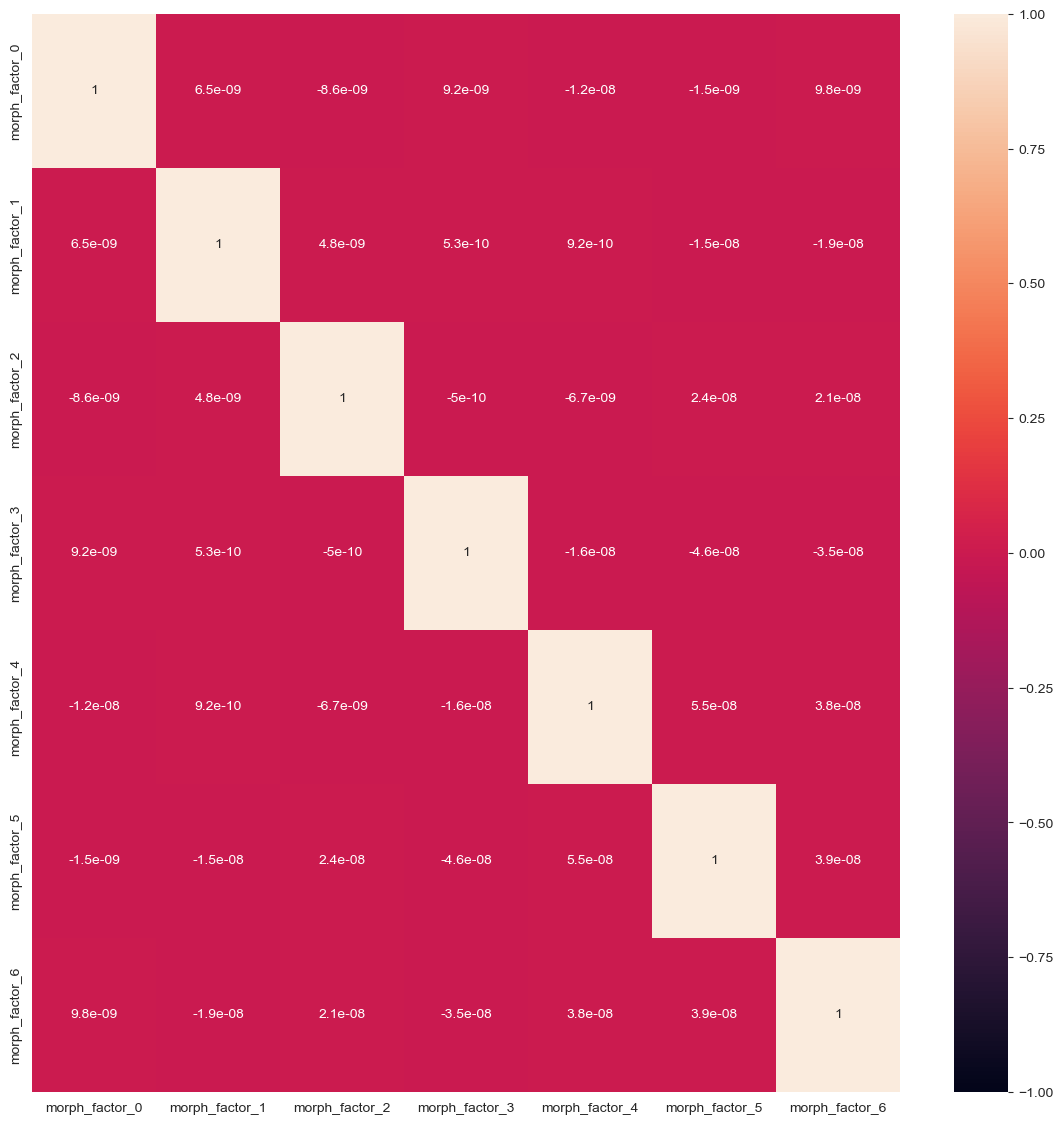

In [51]:
plt.figure(figsize=(14,14))
ax=sns.heatmap(gdf.corr(),vmin=-1,vmax=1,annot=True)

plt.show()

In [52]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure

gdf = gdf.merge(buildings_cate_compressed, on='uID', how='left')


In [53]:
gdf.set_index('uID',inplace=True)

gdf

morph_factor_0  morph_factor_1  morph_factor_2  morph_factor_3  \
uID                                                                    
1084       -0.151534       -0.611756        1.356728       -0.327419   
1061        2.030910       -0.493625        1.692712       -0.572621   
1063        0.233007       -0.459467        1.575313       -0.812511   
1774       -0.011790       -0.578670        1.525203       -0.597783   
1055        0.043963       -0.316361        1.576284       -0.792267   
...              ...             ...             ...             ...   
2404        0.887652       -2.300313       -0.015473        1.086325   
2406        0.524216       -2.859769        0.012892        1.051909   
2405        0.900913       -2.690887       -0.041134        0.890629   
2421        2.252936       -3.542208        0.096297        0.309261   
2285        1.219286       -1.197897       -0.872679       -0.671078   

      morph_factor_4  morph_factor_5  morph_factor_6  功能_休闲娱乐  功能_公司企业  功能_其他  \
uID                                                                             
1084       -0.708635       -0.492642        0.809541        0        0      0   
1061       -0.057866        0.171726        0.142121        0        0      0   
1063       -0.464785        1.525207        0.013051        0        0      0   
1774       -0.521764        1.473582        0.140511        0        0      0   
1055       -0.478597        1.493054        0.082011        0        0      0   
...              ...             ...             ...      ...      ...    ...   
2404       -1.509021        1.370617       -2.709115        0        0      0   
2406       -1.404725        1.388688       -1.773461        0        0      0   
2405       -1.571598        1.149396       -2.478097        0        0      0   
2421       -0.977919        0.311555       -2.430148        0        0      0   
2285       -1.061654        0.498866       -0.522074        0        0      1   

      ...  结构_破  结构_砼  结构_简  产权_公  产权_公（居住）  产权_私  产权_缺  风貌_历史风貌  风貌_混合风貌  \
uID   ...                                                                   
1084  ...     0     0     0     0         0     1     0        0        1   
1061  ...     0     0     0     0         0     0     1        0        1   
1063  ...     0     0     0     0         0     0     1        0        1   
1774  ...     0     0     0     0         0     1     0        0        1   
1055  ...     0     0     0     0         0     0     1        0        1   
...   ...   ...   ...   ...   ...       ...   ...   ...      ...      ...   
2404  ...     0     0     0     0         0     1     0        0        0   
2406  ...     0     0     0     0         0     1     0        0        0   
2405  ...     0     0     0     0         0     1     0        0        0   
2421  ...     0     0     0     0         0     1     0        0        0   
2285  ...     0     0     0     0         0     1     0        0        0   

      风貌_现代风貌  
uID            
1084        0  
1061        0  
1063        0  
1774        0  
1055        0  
...       ...  
2404        1  
2406        1  
2405        1  
2421        1  
2285        1  

[2431 rows x 40 columns]

In [54]:
chars = gdf.columns
means = {}
ranges = {}

for ch in gdf.columns:

    means[ch] = []
    if ch not in cate_namelist:
        ranges[ch] = []


Resolve potential missingness cause by invalid input data. That was not case in the presented case studies but may be case in subsequent research.

Define Theil and Simpson functions.

Skewness is used as an estimation of the distribution. Extremely skewed use HeadTail breaks for Simpson's binning, other Natural Breaks.

In [55]:
skewness = pd.DataFrame(index=chars)
for c in chars:
    skewness.loc[c, 'skewness'] = sp.stats.skew(gdf[c])
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index

for inv in to_invert:
    gdf[inv + '_r'] = gdf[inv].max() - gdf[inv]
inverted = [x for x in gdf.columns if '_r' in x]
headtail = headtail + inverted
natural = [x for x in chars if x not in headtail]

Loop over DataFrame and measure IQM, IQR, IDT and Simpson.

In [56]:
# print(type(spatial_weights.neighbors))
# print(spatial_weights.neighbors.keys())
gdf

morph_factor_0  morph_factor_1  morph_factor_2  morph_factor_3  \
uID                                                                    
1084       -0.151534       -0.611756        1.356728       -0.327419   
1061        2.030910       -0.493625        1.692712       -0.572621   
1063        0.233007       -0.459467        1.575313       -0.812511   
1774       -0.011790       -0.578670        1.525203       -0.597783   
1055        0.043963       -0.316361        1.576284       -0.792267   
...              ...             ...             ...             ...   
2404        0.887652       -2.300313       -0.015473        1.086325   
2406        0.524216       -2.859769        0.012892        1.051909   
2405        0.900913       -2.690887       -0.041134        0.890629   
2421        2.252936       -3.542208        0.096297        0.309261   
2285        1.219286       -1.197897       -0.872679       -0.671078   

      morph_factor_4  morph_factor_5  morph_factor_6  功能_休闲娱乐  功能_公司企业  功能_其他  \
uID                                                                             
1084       -0.708635       -0.492642        0.809541        0        0      0   
1061       -0.057866        0.171726        0.142121        0        0      0   
1063       -0.464785        1.525207        0.013051        0        0      0   
1774       -0.521764        1.473582        0.140511        0        0      0   
1055       -0.478597        1.493054        0.082011        0        0      0   
...              ...             ...             ...      ...      ...    ...   
2404       -1.509021        1.370617       -2.709115        0        0      0   
2406       -1.404725        1.388688       -1.773461        0        0      0   
2405       -1.571598        1.149396       -2.478097        0        0      0   
2421       -0.977919        0.311555       -2.430148        0        0      0   
2285       -1.061654        0.498866       -0.522074        0        0      1   

      ...  结构_砼  结构_简  产权_公  产权_公（居住）  产权_私  产权_缺  风貌_历史风貌  风貌_混合风貌  风貌_现代风貌  \
uID   ...                                                                      
1084  ...     0     0     0         0     1     0        0        1        0   
1061  ...     0     0     0         0     0     1        0        1        0   
1063  ...     0     0     0         0     0     1        0        1        0   
1774  ...     0     0     0         0     1     0        0        1        0   
1055  ...     0     0     0         0     0     1        0        1        0   
...   ...   ...   ...   ...       ...   ...   ...      ...      ...      ...   
2404  ...     0     0     0         0     1     0        0        0        1   
2406  ...     0     0     0         0     1     0        0        0        1   
2405  ...     0     0     0         0     1     0        0        0        1   
2421  ...     0     0     0         0     1     0        0        0        1   
2285  ...     0     0     0         0     1     0        0        0        1   

      结构_混_r  
uID           
1084       0  
1061       0  
1063       0  
1774       0  
1055       0  
...      ...  
2404       0  
2406       0  
2405       0  
2421       0  
2285       0  

[2431 rows x 41 columns]

In [57]:
# 因为有些buildings丢失了，所以只能在现在存在的buildings索引上跑一遍
index_list=list(gdf.index.values)
for index in tqdm(index_list, total=gdf.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]  
    subset = gdf.loc[neighbours]
    for ch in chars:
        values_list = subset[ch] 
        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(0, 100))
        value=values_list[index]
        means[ch].append(np.mean(iquar)*0.25+value*0.75)
        if ch not in cate_namelist:
            ranges[ch].append(max(iquar) - min(iquar))
        # theils[ch].append(_theil(idec))
        
        # sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
        # counts = dict(zip(bins[ch], sample_bins.counts))
        # simpsons[ch].append(_simpson_di(counts))

100%|██████████| 2431/2431 [00:28<00:00, 86.49it/s]


In [58]:
contextual = {}
for ch in chars:
    contextual[ch + '_mean'] = means[ch]
    if ch not in cate_namelist:
        contextual[ch + '_range'] = ranges[ch]
    # contextual[ch + '_theilID3'] = theils[ch]
    # contextual[ch + '_simpson'] = simpsons[ch]

contextual = pd.DataFrame(contextual, index=gdf.index)

In [59]:
contextual.shape
contextual

morph_factor_0_mean  morph_factor_0_range  morph_factor_1_mean  \
uID                                                                    
1084            -0.093940              2.106970            -0.539712   
1061             1.575381              2.458812            -0.483043   
1063             0.276598              2.079189            -0.459213   
1774             0.039984              2.458812            -0.541090   
1055             0.094190              2.458812            -0.328703   
...                   ...                   ...                  ...   
2404             0.672930              2.192390            -2.282327   
2406             0.540840              2.800942            -2.848606   
2405             0.761242              2.830284            -2.685851   
2421             1.882299              2.800942            -3.377442   
2285             1.219286              0.000000            -1.197897   

      morph_factor_1_range  morph_factor_2_mean  morph_factor_2_range  \
uID                                                                     
1084              1.493116             1.370289              1.199168   
1061              1.380937             1.652925              0.275104   
1063              0.783744             1.567186              0.275104   
1774              0.820877             1.529071              0.275104   
1055              0.812740             1.568664              0.226332   
...                    ...                  ...                   ...   
2404              3.711643            -0.059044              0.817149   
2406              1.446401             0.008780              0.619199   
2405              3.294993            -0.052853              0.680729   
2421              1.265401             0.088575              0.395952   
2285              0.000000            -0.872679              0.000000   

      morph_factor_3_mean  morph_factor_3_range  morph_factor_4_mean  \
uID                                                                    
1084            -0.330488              4.634689            -0.693100   
1061            -0.660476              0.527034            -0.137839   
1063            -0.825518              0.516682            -0.436750   
1774            -0.674310              0.516682            -0.492198   
1055            -0.827087              0.522405            -0.456626   
...                   ...                   ...                  ...   
2404             0.904516              1.399580            -1.497744   
2406             0.865525              1.288379            -1.373491   
2405             0.762257              1.399580            -1.521684   
2421             0.293863              1.253963            -1.047577   
2285            -0.671078              0.000000            -1.061654   

      morph_factor_4_range  ...  结构_破_mean  结构_砼_mean  结构_简_mean  产权_公_mean  \
uID                         ...                                               
1084              2.114359  ...        0.0        0.0   0.000000   0.000000   
1061              0.480493  ...        0.0        0.0   0.000000   0.000000   
1063              0.463898  ...        0.0        0.0   0.000000   0.000000   
1774              0.480493  ...        0.0        0.0   0.000000   0.000000   
1055              0.480493  ...        0.0        0.0   0.000000   0.000000   
...                    ...  ...        ...        ...        ...        ...   
2404              0.887540  ...        0.0        0.0   0.111111   0.055556   
2406              0.619575  ...        0.0        0.0   0.053571   0.000000   
2405              0.859540  ...        0.0        0.0   0.093750   0.000000   
2421              0.619575  ...        0.0        0.0   0.050000   0.000000   
2285              0.000000  ...        0.0        0.0   0.000000   0.000000   

      产权_公（居住）_mean  产权_私_mean  产权_缺_mean  风貌_历史风貌_mean  风貌_混合风貌_mean  \
uID                                                                     
1084    

In [134]:
contextual.to_parquet('../files/contextual.parquet')

## Clustering

We use contextual characters to do GMM clustering.

In [135]:
data = contextual.copy()

First we standardize data.

In [136]:
# normalise data
x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

sum=0
count_change=list1[-1]
for count in reversed(list1):
    if sum==0:
        data.iloc[:,sum-count:]=data.iloc[:,sum-count:]/np.sqrt(count)
    else:
        data.iloc[:,-sum-count:-sum]=data.iloc[:,-sum-count:-sum]/np.sqrt(count)
    sum+=count
data.iloc[:,-count_change:]=data.iloc[:,-count_change:]
data



morph_factor_0_mean  morph_factor_0_range  morph_factor_1_mean  \
uID                                                                    
1084            -0.165459             -0.498854            -0.610969   
1061             1.983795             -0.404330            -0.546748   
1063             0.311609             -0.506318            -0.519741   
1774             0.006969             -0.404330            -0.612531   
1055             0.076759             -0.404330            -0.371838   
...                   ...                   ...                  ...   
2404             0.821888             -0.475906            -2.585833   
2406             0.651822             -0.312414            -3.227583   
2405             0.935590             -0.304531            -3.043137   
2421             2.378952             -0.312414            -3.826901   
2285             1.525322             -1.064906            -1.356874   

      morph_factor_1_range  morph_factor_2_mean  morph_factor_2_range  \
uID                                                                     
1084             -1.700545             1.453389             -0.272633   
1061             -1.867204             1.752735             -1.205939   
1063             -2.754421             1.661926             -1.205939   
1774             -2.699255             1.621558             -1.205939   
1055             -2.711344             1.663492             -1.255199   
...                    ...                  ...                   ...   
2404              1.595402            -0.060447             -0.658472   
2406             -1.769947             0.011387             -0.858402   
2405              0.976408            -0.053890             -0.796258   
2421             -2.038849             0.095900             -1.083882   
2285             -3.918788            -0.922184             -1.483795   

      morph_factor_3_mean  morph_factor_3_range  morph_factor_4_mean  \
uID                                                                    
1084            -0.364261              2.071738            -0.735147   
1061            -0.727139             -1.491311            -0.148556   
1063            -0.908630             -1.500290            -0.464333   
1774            -0.742351             -1.500290            -0.522909   
1055            -0.910356             -1.495326            -0.485330   
...                   ...                   ...                  ...   
2404             0.993835             -0.734450            -1.585193   
2406             0.950958             -0.830907            -1.453928   
2405             0.837397             -0.734450            -1.610484   
2421             0.322318             -0.860760            -1.109625   
2285            -0.738797             -1.948469            -1.124496   

      morph_factor_4_range  ...  结构_破_mean  结构_砼_mean  结构_简_mean  产权_公_mean  \
uID                         ...                                               
1084              0.535183  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1061             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1063             -1.454538  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1774             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1055             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
...                    ...  ...        ...        ...        ...        ...   
2404             -0.943814  ...  -0.037009  -0.041402   0.339442  -0.135155   
2406             -1.266862  ...  -0.037009  -0.041402   0.121273  -0.223551   
2405             -0.977570  ...  -0.037009  -0.041402   0.273615  -0.223551   
2421             -1.266862  ...  -0.037009  -0.041402   0.107731  -0.223551   
2285             -2.013793  ...  -0.037009  -0.041402  -0.081850  -0.223551   

      产权_公（居住）_mean  产权_私_mean  产权_缺_mean  风貌_历史风貌_mean  风貌_混合风貌_mean  \
uID                                                                     
1084    

In [137]:
data_new=data
data_new

morph_factor_0_mean  morph_factor_0_range  morph_factor_1_mean  \
uID                                                                    
1084            -0.165459             -0.498854            -0.610969   
1061             1.983795             -0.404330            -0.546748   
1063             0.311609             -0.506318            -0.519741   
1774             0.006969             -0.404330            -0.612531   
1055             0.076759             -0.404330            -0.371838   
...                   ...                   ...                  ...   
2404             0.821888             -0.475906            -2.585833   
2406             0.651822             -0.312414            -3.227583   
2405             0.935590             -0.304531            -3.043137   
2421             2.378952             -0.312414            -3.826901   
2285             1.525322             -1.064906            -1.356874   

      morph_factor_1_range  morph_factor_2_mean  morph_factor_2_range  \
uID                                                                     
1084             -1.700545             1.453389             -0.272633   
1061             -1.867204             1.752735             -1.205939   
1063             -2.754421             1.661926             -1.205939   
1774             -2.699255             1.621558             -1.205939   
1055             -2.711344             1.663492             -1.255199   
...                    ...                  ...                   ...   
2404              1.595402            -0.060447             -0.658472   
2406             -1.769947             0.011387             -0.858402   
2405              0.976408            -0.053890             -0.796258   
2421             -2.038849             0.095900             -1.083882   
2285             -3.918788            -0.922184             -1.483795   

      morph_factor_3_mean  morph_factor_3_range  morph_factor_4_mean  \
uID                                                                    
1084            -0.364261              2.071738            -0.735147   
1061            -0.727139             -1.491311            -0.148556   
1063            -0.908630             -1.500290            -0.464333   
1774            -0.742351             -1.500290            -0.522909   
1055            -0.910356             -1.495326            -0.485330   
...                   ...                   ...                  ...   
2404             0.993835             -0.734450            -1.585193   
2406             0.950958             -0.830907            -1.453928   
2405             0.837397             -0.734450            -1.610484   
2421             0.322318             -0.860760            -1.109625   
2285            -0.738797             -1.948469            -1.124496   

      morph_factor_4_range  ...  结构_破_mean  结构_砼_mean  结构_简_mean  产权_公_mean  \
uID                         ...                                               
1084              0.535183  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1061             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1063             -1.454538  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1774             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1055             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
...                    ...  ...        ...        ...        ...        ...   
2404             -0.943814  ...  -0.037009  -0.041402   0.339442  -0.135155   
2406             -1.266862  ...  -0.037009  -0.041402   0.121273  -0.223551   
2405             -0.977570  ...  -0.037009  -0.041402   0.273615  -0.223551   
2421             -1.266862  ...  -0.037009  -0.041402   0.107731  -0.223551   
2285             -2.013793  ...  -0.037009  -0.041402  -0.081850  -0.223551   

      产权_公（居住）_mean  产权_私_mean  产权_缺_mean  风貌_历史风貌_mean  风貌_混合风貌_mean  \
uID                                                                     
1084    

morph_factor_0_mean  morph_factor_0_range  morph_factor_1_mean  \
uID                                                                    
1084            -0.165459             -0.498854            -0.610969   
1061             1.983795             -0.404330            -0.546748   
1063             0.311609             -0.506318            -0.519741   
1774             0.006969             -0.404330            -0.612531   
1055             0.076759             -0.404330            -0.371838   
...                   ...                   ...                  ...   
2404             0.821888             -0.475906            -2.585833   
2406             0.651822             -0.312414            -3.227583   
2405             0.935590             -0.304531            -3.043137   
2421             2.378952             -0.312414            -3.826901   
2285             1.525322             -1.064906            -1.356874   

      morph_factor_1_range  morph_factor_2_mean  morph_factor_2_range  \
uID                                                                     
1084             -1.700545             1.453389             -0.272633   
1061             -1.867204             1.752735             -1.205939   
1063             -2.754421             1.661926             -1.205939   
1774             -2.699255             1.621558             -1.205939   
1055             -2.711344             1.663492             -1.255199   
...                    ...                  ...                   ...   
2404              1.595402            -0.060447             -0.658472   
2406             -1.769947             0.011387             -0.858402   
2405              0.976408            -0.053890             -0.796258   
2421             -2.038849             0.095900             -1.083882   
2285             -3.918788            -0.922184             -1.483795   

      morph_factor_3_mean  morph_factor_3_range  morph_factor_4_mean  \
uID                                                                    
1084            -0.364261              2.071738            -0.735147   
1061            -0.727139             -1.491311            -0.148556   
1063            -0.908630             -1.500290            -0.464333   
1774            -0.742351             -1.500290            -0.522909   
1055            -0.910356             -1.495326            -0.485330   
...                   ...                   ...                  ...   
2404             0.993835             -0.734450            -1.585193   
2406             0.950958             -0.830907            -1.453928   
2405             0.837397             -0.734450            -1.610484   
2421             0.322318             -0.860760            -1.109625   
2285            -0.738797             -1.948469            -1.124496   

      morph_factor_4_range  ...  结构_破_mean  结构_砼_mean  结构_简_mean  产权_公_mean  \
uID                         ...                                               
1084              0.535183  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1061             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1063             -1.454538  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1774             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
1055             -1.434532  ...  -0.037009  -0.041402  -0.081850  -0.223551   
...                    ...  ...        ...        ...        ...        ...   
2404             -0.943814  ...  -0.037009  -0.041402   0.339442  -0.135155   
2406             -1.266862  ...  -0.037009  -0.041402   0.121273  -0.223551   
2405             -0.977570  ...  -0.037009  -0.041402   0.273615  -0.223551   
2421             -1.266862  ...  -0.037009  -0.041402   0.107731  -0.223551   
2285             -2.013793  ...  -0.037009  -0.041402  -0.081850  -0.223551   

      产权_公（居住）_mean  产权_私_mean  产权_缺_mean  风貌_历史风貌_mean  风貌_混合风貌_mean  \
uID                                                                     
1084    

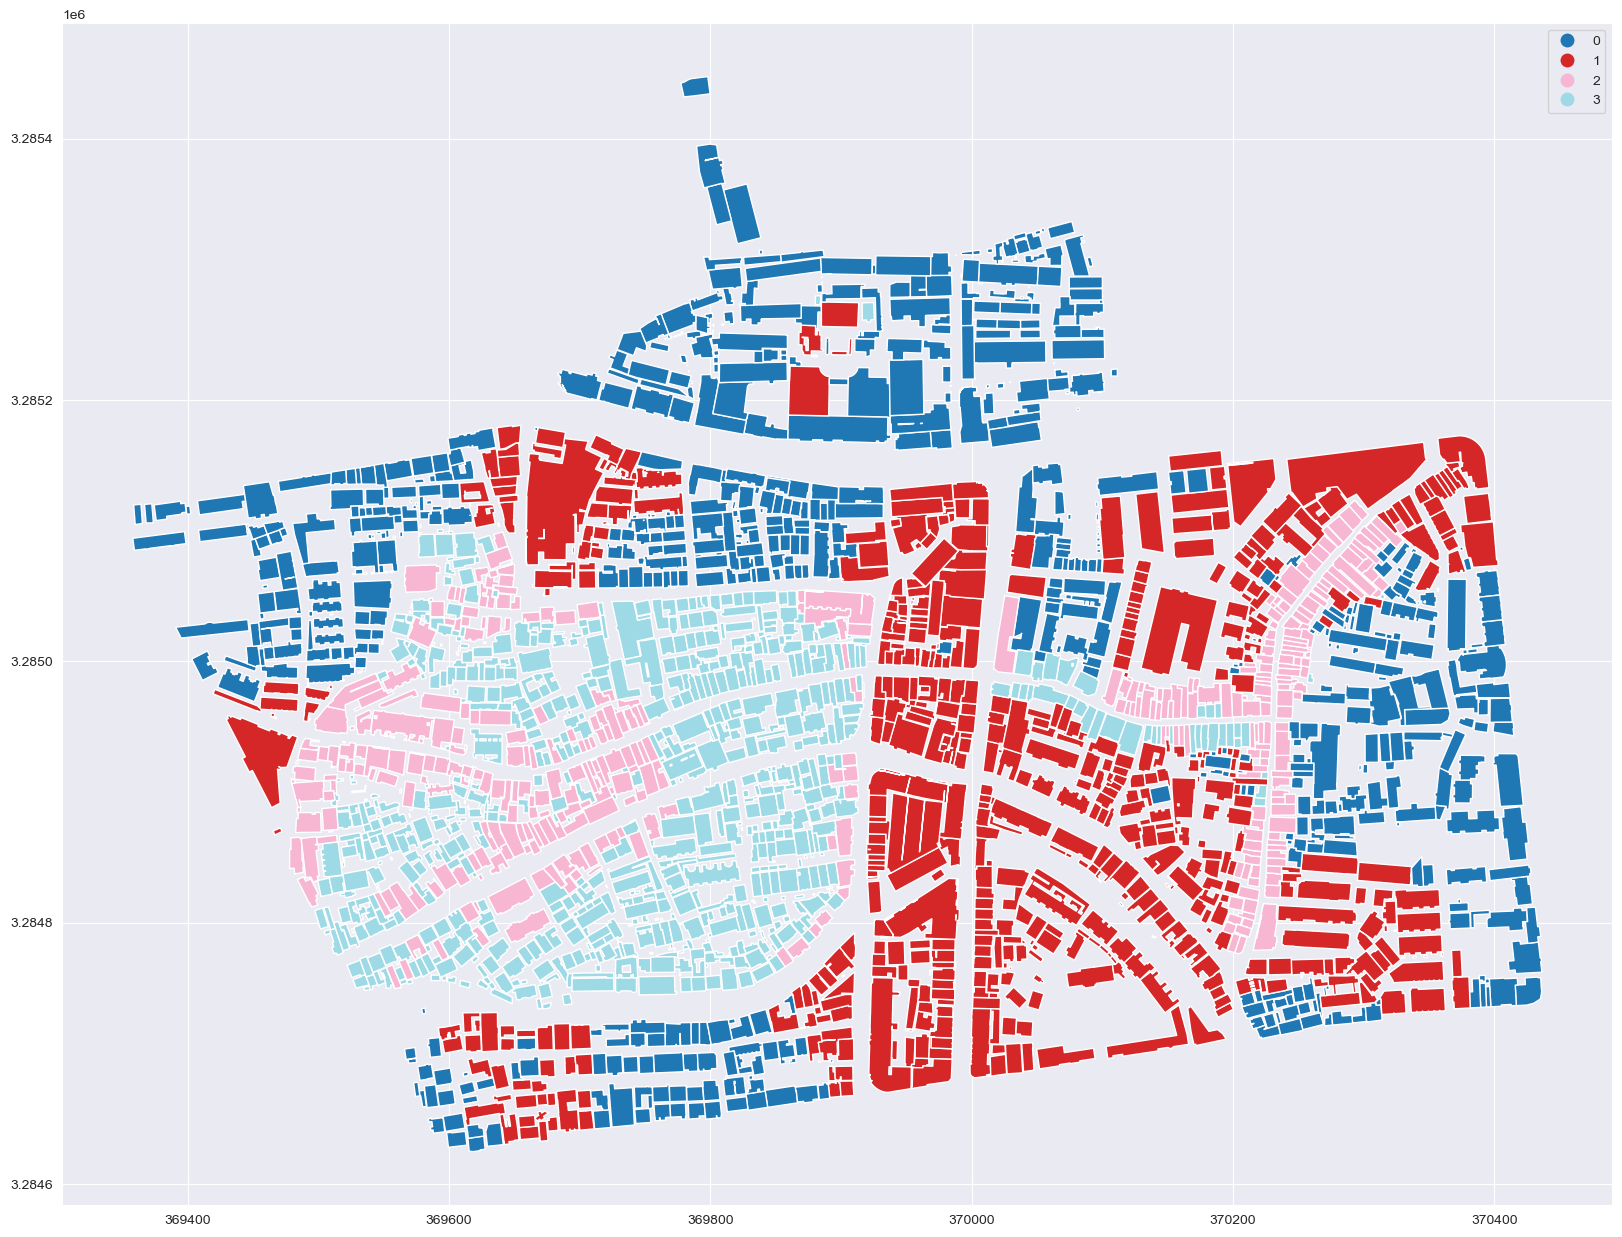

In [113]:
data = contextual.copy()
x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

sum=0
count_change=list1[-1]
for count in reversed(list1):
    if sum==0:
        data.iloc[:,sum-count:]=data.iloc[:,sum-count:]/np.sqrt(count)
    else:
        data.iloc[:,-sum-count:-sum]=data.iloc[:,-sum-count:-sum]/np.sqrt(count)
    sum+=count
# data.iloc[:,:-sum]=data.iloc[:,:-sum]*3
data.iloc[:,-count_change:]=data.iloc[:,-count_change:]*2
km = BisectingKMeans(n_clusters=4)
data_new=data
km.fit(data_new)
labels_km = km.predict(data_new)
buildings.loc[index_list].plot(labels_km, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))
data_new=data
data_new

# K-Means

In [65]:
# specify how many times should each option be tried (more better, but takes a long time)

In [126]:
data = contextual.copy()
distance_list=list()
k_list=list()
score_list=list()
for k in range(2,15):
    km=BisectingKMeans(n_clusters=k)
    km.fit(data_new)
    k_list.append(k)
    distance_list.append(km.inertia_)
    score_list.append(silhouette_score(data_new,km.labels_))


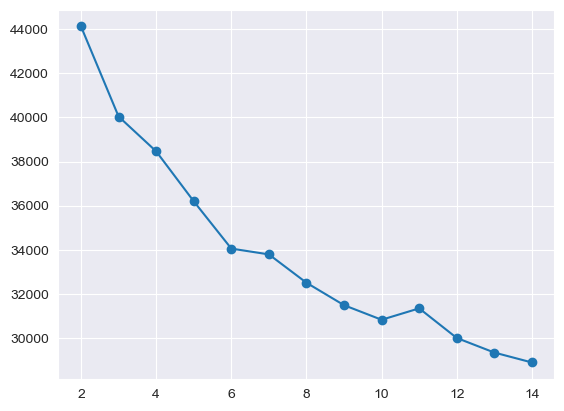

In [127]:
plt.plot(k_list,distance_list,marker='o')

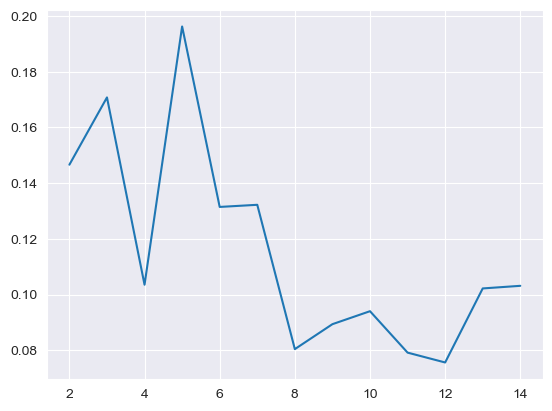

In [128]:
plt.plot(k_list,score_list)

In [138]:
km=BisectingKMeans(n_clusters=4)
km.fit(data_new)
labels_km=km.predict(data_new)

pd.Series(labels_km, index=data.index).to_csv('../files/cluster_labels_km.csv')
labels_km

array([1, 1, 1, ..., 1, 1, 1])

<AxesSubplot: >

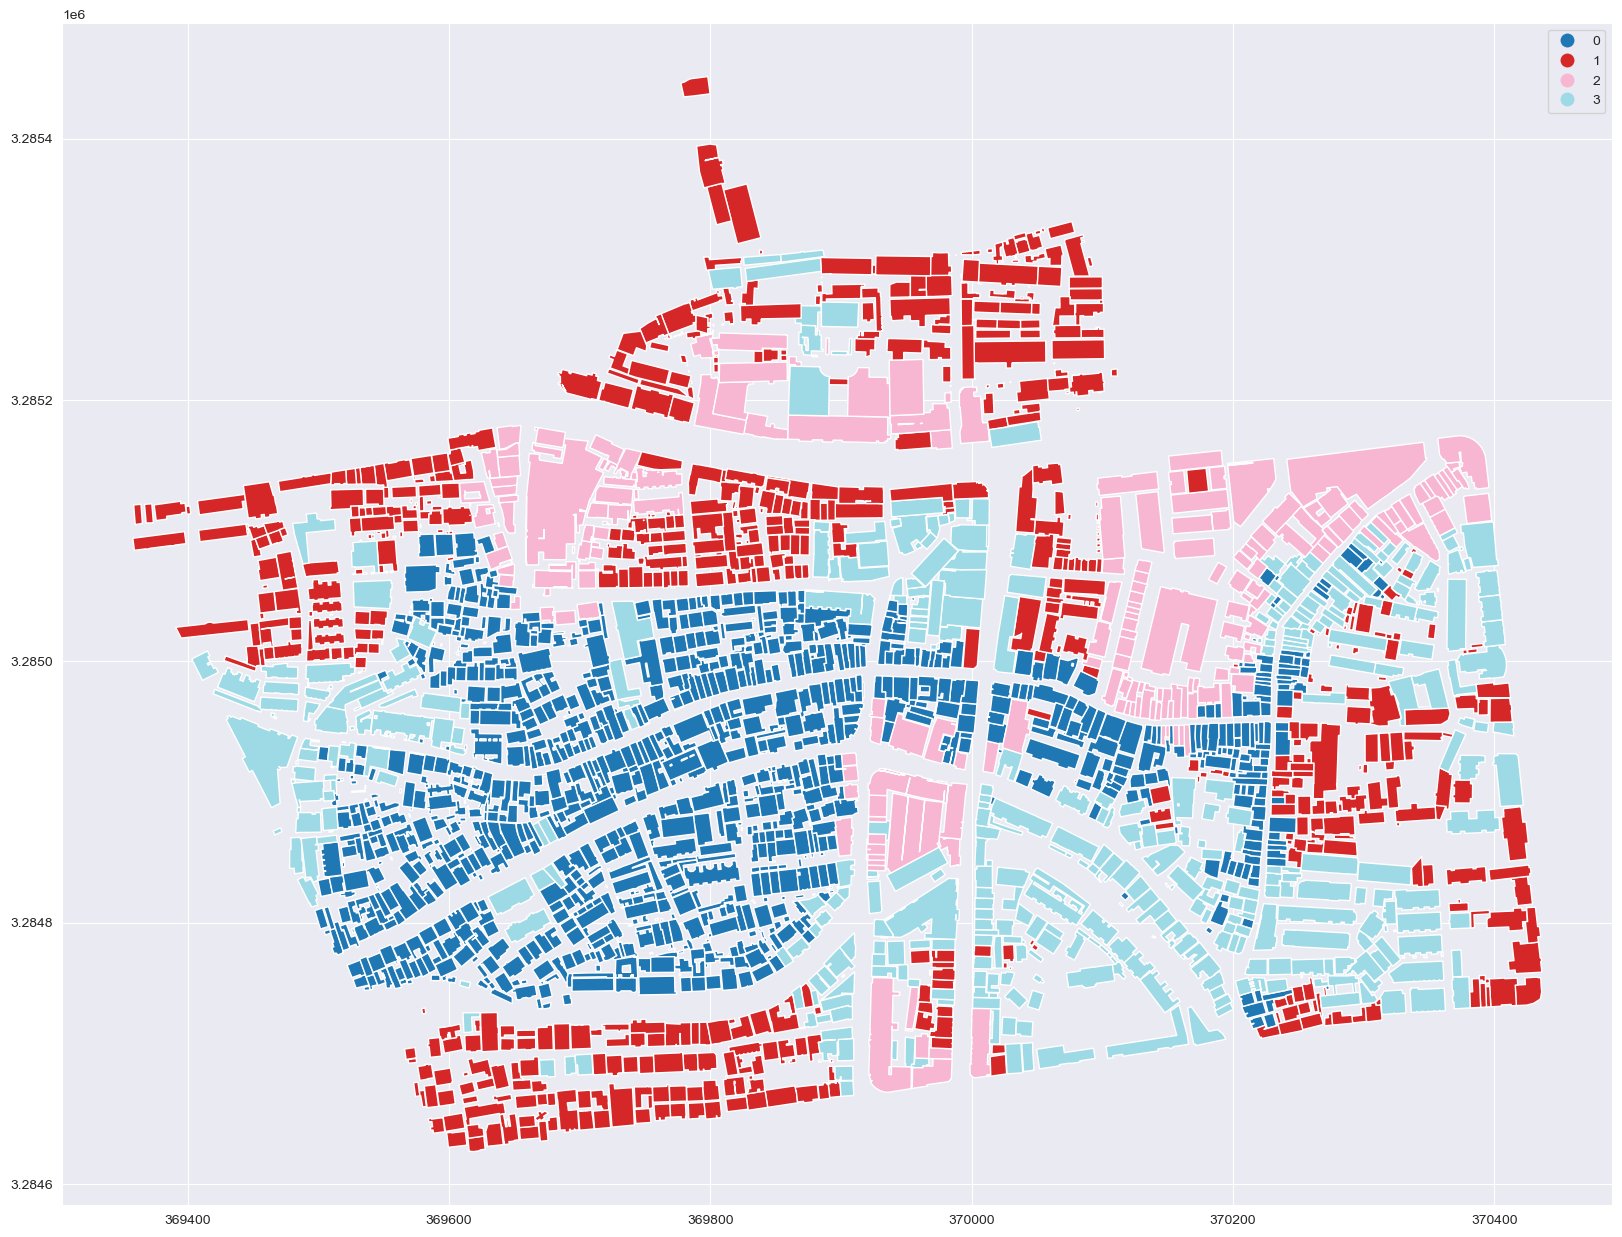

In [139]:
buildings.loc[index_list].plot(labels_km, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))

In [71]:
centerpoints=km.cluster_centers_
labels_km_df=pd.DataFrame(labels_km,index=index_list)


In [72]:
labels_km_df.index.name='uID'
labels_km_df.columns=['labels']
labels_km_df

labels
uID         
1084       0
1061       0
1063       0
1774       0
1055       0
...      ...
2404       3
2406       3
2405       3
2421       3
2285       3

[2431 rows x 1 columns]

In [73]:
# data_new=data_new.drop(['distance','labels'],axis=1)
# data_new


In [74]:
for d_index,d_row in data_new.iterrows():
    label=labels_km_df.loc[d_index][0]
    distance=sp.spatial.distance.euclidean(d_row.values,centerpoints[label])
    data_new.loc[d_index,'distance']=distance

data_new['labels']=labels_km_df['labels']

data_grouped=data_new.groupby(['labels'])
prototype_5points={}
for df in data_grouped:
    df=pd.DataFrame(df[1])
    l=df['labels'].values[0]
    df=df.sort_values(by=['distance'],ascending=True)
    a=list(df.index.values)
    prototype_5points[f'cluster_{l}']=buildings_new.loc[a,:].head(5)
prototype={}
for i in range(len(centerpoints)):
    prototype[f'cluster_{i}']=prototype_5points[f'cluster_{i}'].mean()





C:\Users\YAGA\AppData\Local\Temp\ipykernel_26132\1092055867.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for df in data_grouped:


In [75]:
pd.DataFrame(prototype).round(4).T.to_csv('5点算的原型.csv')
pd.DataFrame(prototype).round(4).T

功能_休闲娱乐  功能_公司企业  功能_其他  功能_医疗  功能_商业服务  功能_居住  功能_政府机构  功能_教育培训  \
cluster_0      0.0      0.0    0.0    0.0      0.0    0.8      0.0      0.0   
cluster_1      0.0      0.0    0.0    0.0      0.0    1.0      0.0      0.0   
cluster_2      0.0      0.0    0.0    0.0      0.0    1.0      0.0      0.0   
cluster_3      0.0      0.0    0.0    0.0      0.0    1.0      0.0      0.0   

           功能_生活服务  功能_综合  ...  ssbElo   stbOri  mtbSWR  mtbAli  mtbNDi  \
cluster_0      0.0    0.0  ...  0.5466  11.8716  0.1553  4.0279  2.2930   
cluster_1      0.0    0.0  ...  0.6095   6.4896  0.1671  3.4815  2.7027   
cluster_2      0.0    0.0  ...  0.5292  14.1604  0.2218  3.5270  1.3918   
cluster_3      0.0    0.0  ...  0.5080   5.8902  0.4753  1.9073  1.8347   

               ldkAre    ldkPer   ltkOri  ltkWNB  likWBB  
cluster_0  11732.8439  480.9292  10.0058  0.0107  0.0050  
cluster_1  15732.8698  598.2357   5.2764  0.0087  0.0046  
cluster_2   9210.9609  448.1607  20.9823  0.0106  0.0069  
cluster_3  17804.7354  770.1084  10.1493  0.0033  0.0029  

[4 rows x 58 columns]

In [76]:
prototype_df=data_new.groupby('labels')['distance'].idxmin()
prototype_df=pd.merge(prototype_df,buildings,left_on='distance',right_on='uID',how='left')
prototype_df.to_csv('原型建筑.csv')
prototype_df

distance  height  功能  材质 结构 产权    风貌  \
0      1144   24.38  居住  涂料  混  私  混合风貌   
1       549   27.69  居住  面砖  混  缺  现代风貌   
2      1679   21.46  居住  涂料  混  缺  历史风貌   
3      1012   21.42  居住  涂料  混  公  现代风貌   

                                            geometry       Peri        Area  \
0  POLYGON ((370038.547 3284789.048, 370038.168 3...  38.913423   73.637139   
1  POLYGON ((369485.080 3284982.941, 369484.932 3...  71.757859  225.095242   
2  POLYGON ((369545.274 3284763.261, 369547.936 3...  34.268394   49.061644   
3  POLYGON ((369449.530 3285011.391, 369447.528 3...  48.496667  117.414121   

    uID  
0  1144  
1   549  
2  1679  
3  1012

In [77]:
bic = pd.DataFrame(columns=['n', 'bic', 'run'])
ix = 0

n_components_range = range(2,20) # specify range you want to assess. 2-8 is sensible for the sample, not the whole city
gmmruns = 10
data = data.fillna(0)
for n_components in n_components_range:
    for i in range(gmmruns):
        gmm = GaussianMixture(n_components=n_components, covariance_type="full", max_iter=200, n_init=1, verbose=0)
        fitted = gmm.fit(data)
        bicnum = gmm.bic(data)
        bic.loc[ix] = [n_components, bicnum, i]
        ix += 1

        print(n_components, i, "BIC:", bicnum)

2 0 BIC: -246557.52882400688
2 1 BIC: -246555.53414966186
2 2 BIC: -246557.52882400688
2 3 BIC: -246555.53414966186
2 4 BIC: -246555.53414966186
2 5 BIC: -246557.52882400688
2 6 BIC: -246555.53414966186
2 7 BIC: -246557.52882400688
2 8 BIC: -246555.53414966186
2 9 BIC: -246555.53414966186
3 0 BIC: -257577.7629499123
3 1 BIC: -257578.05602379187
3 2 BIC: -257577.76294988047
3 3 BIC: -304668.6680896037
3 4 BIC: -257578.05602379187
3 5 BIC: -257578.05602379187
3 6 BIC: -247322.33239330744
3 7 BIC: -257578.05602379187
3 8 BIC: -247322.32928765737
3 9 BIC: -257578.05602379187
4 0 BIC: -295986.0075288828
4 1 BIC: -295986.0419504606
4 2 BIC: -295986.0362178991
4 3 BIC: -295986.04195035837
4 4 BIC: -286697.85382452304
4 5 BIC: -320466.99036830093
4 6 BIC: -295986.0362178991
4 7 BIC: -295986.04194999975
4 8 BIC: -295986.05217205436
4 9 BIC: -295986.0339332895
5 0 BIC: -315455.5839755021
5 1 BIC: -315459.7882047764
5 2 BIC: -308296.60944374005
5 3 BIC: -307401.3921582498
5 4 BIC: -311887.4032548

In [78]:
bic.to_csv('../files/complete_BIC.csv')

Based on the plot below, we estimate the optimal `n` either based on the elbow of the curve or as the minimum.

<AxesSubplot: xlabel='n', ylabel='bic'>

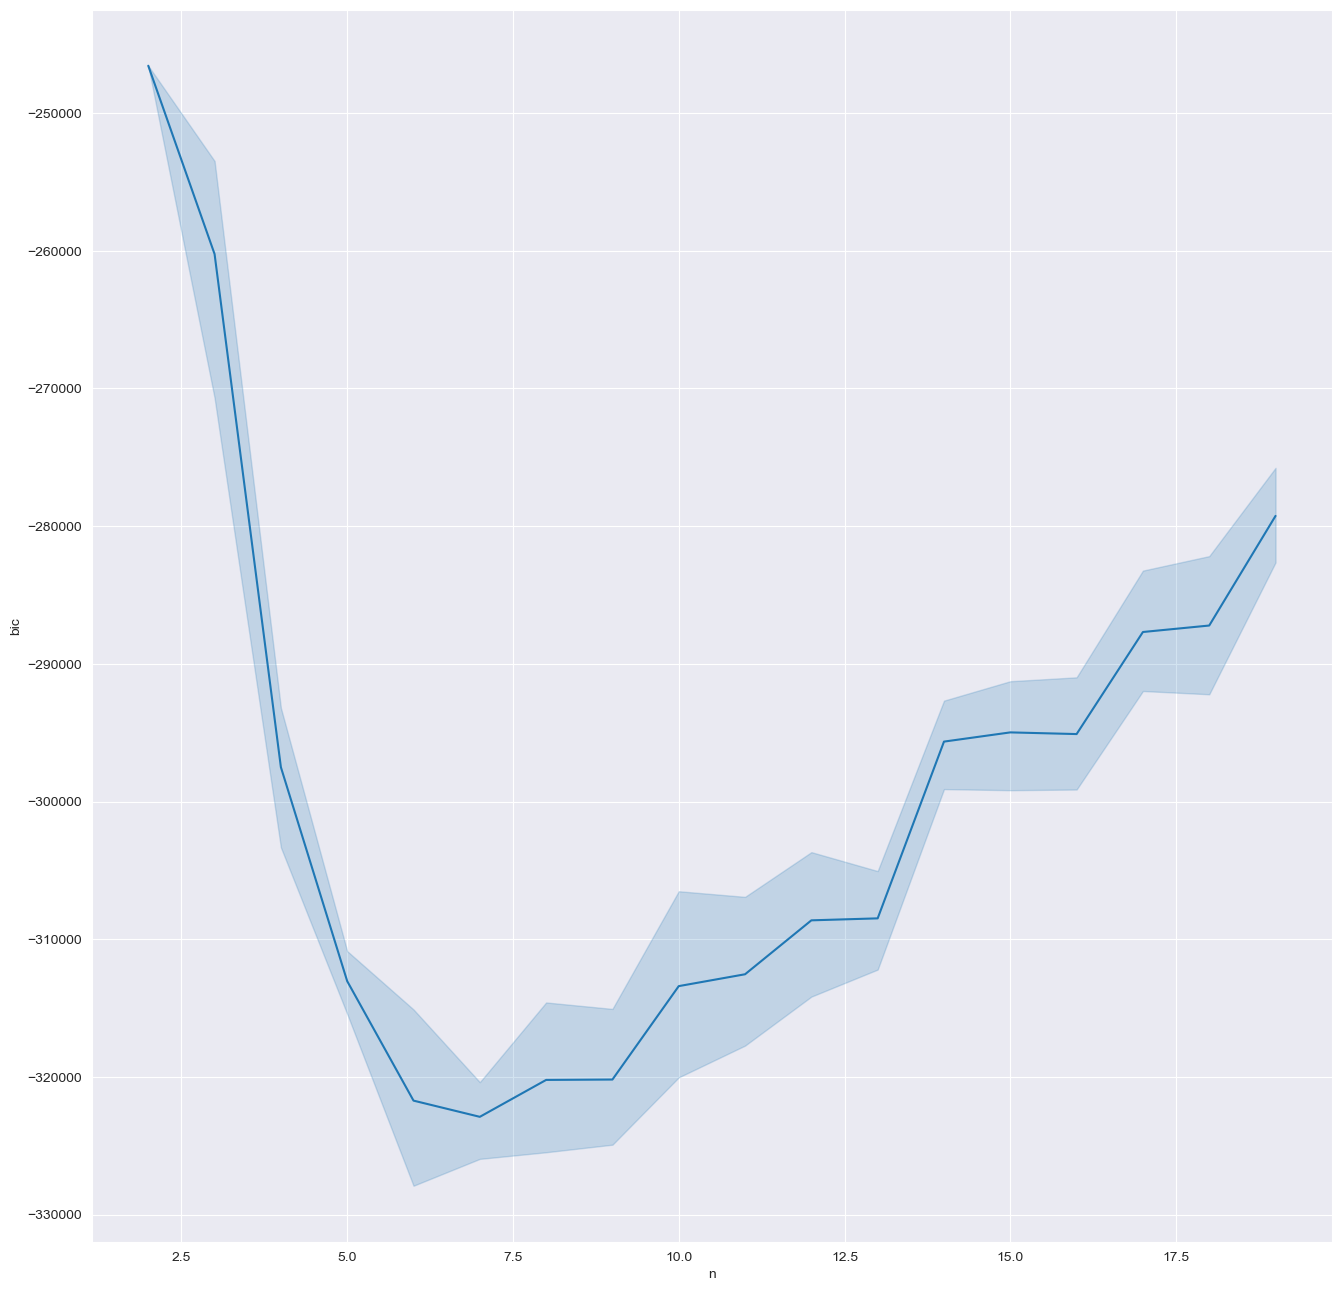

In [79]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='bic', data=bic)
# plt.savefig('../files/complete_BIC.pdf')

### Gaussian Mixture Model

In [80]:


n2 = 7  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init2 = 10  # more initialization, more stable clustering gets

gmm2 = GaussianMixture(n_components=n2, covariance_type="full", max_iter=200, n_init=n_init2, verbose=1)

fitted2 = gmm2.fit(data)

Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True
Initialization 5
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 6
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 7
  Iteration 10
Initialization converged: True
Initialization 8
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 9
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


In [81]:

labels2 = gmm2.predict(data)

In [82]:
pd.Series(labels2, index=data.index).to_csv('../files/cluster_labels2_gmm.csv')

#### Hierachical clustering

Finally, we create hierarchical classification - taxonomy.

## Results

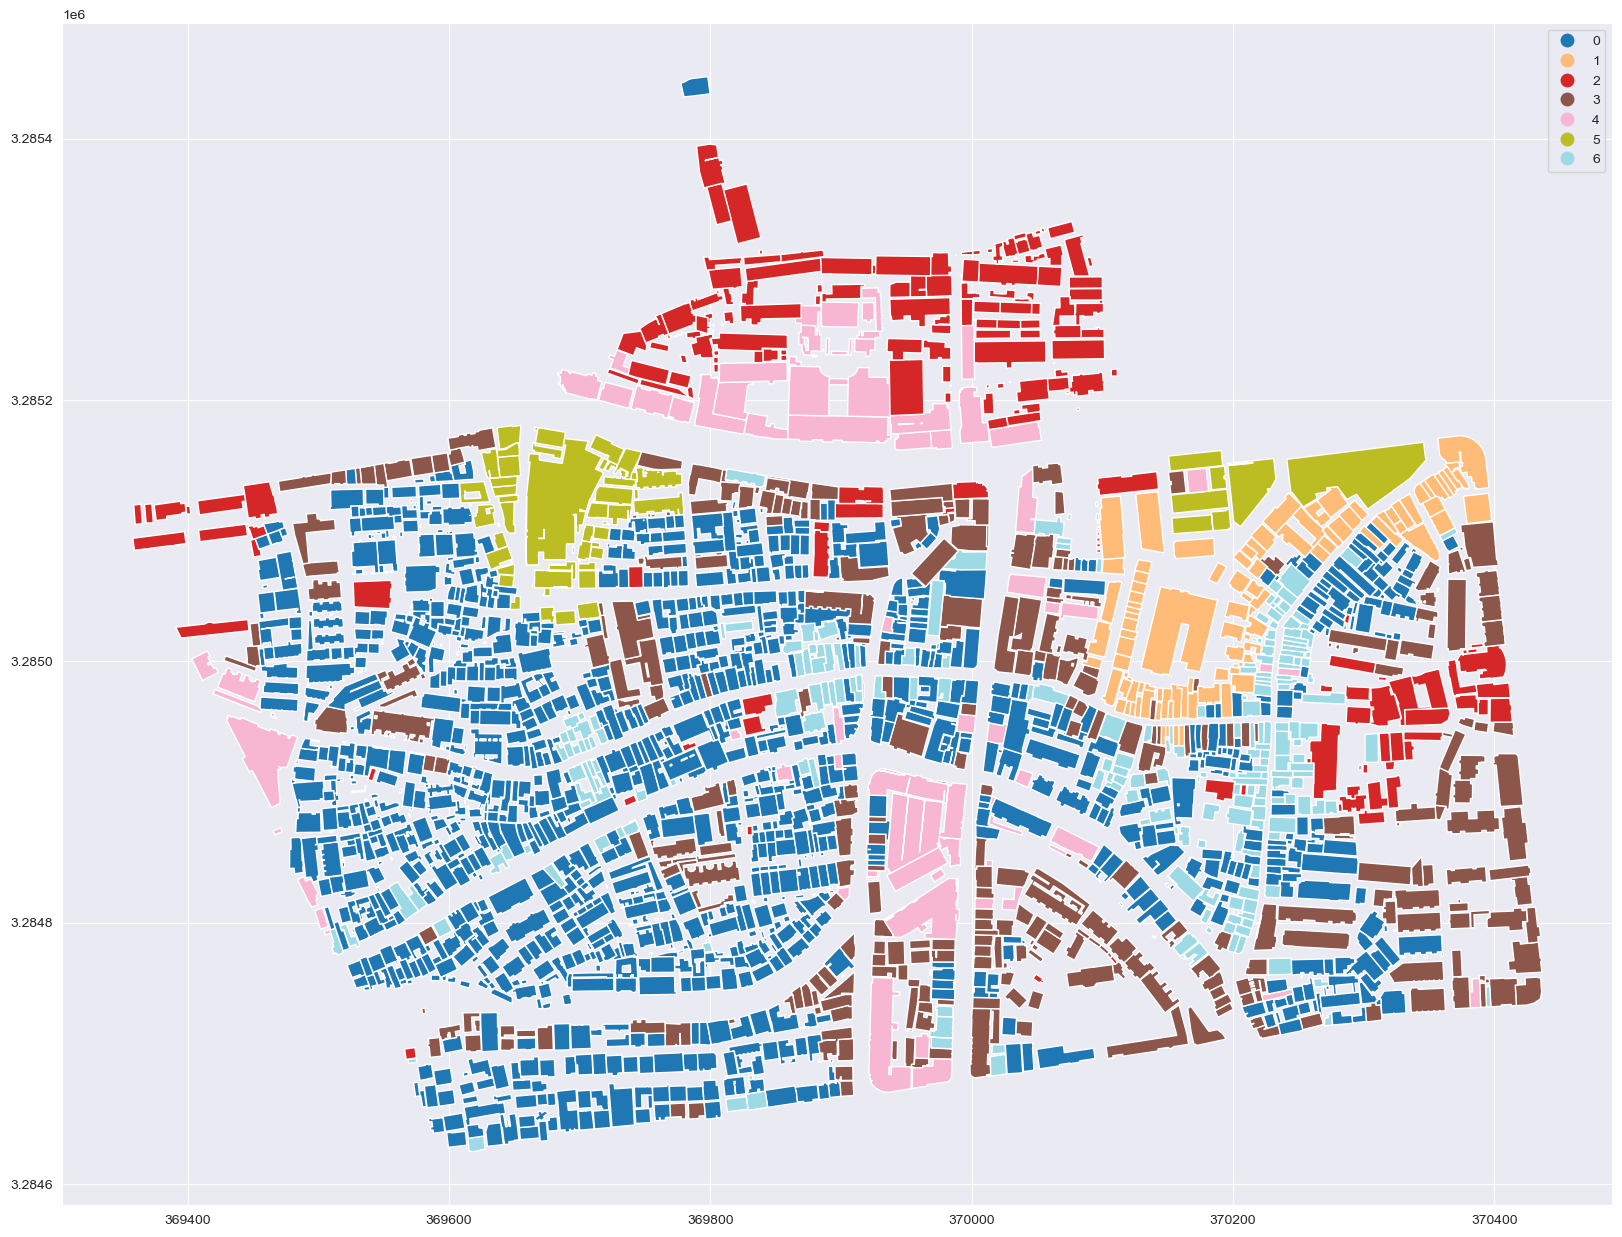

In [83]:
# 分10类
ax=buildings.loc[index_list].plot(labels2, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))
fig=ax.get_figure()
fig.savefig('fig.png')